In [1]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import dtreeviz


import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif, f_classif

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, balanced_accuracy_score, recall_score, \
                            f1_score, fbeta_score, matthews_corrcoef, roc_auc_score, classification_report, \
                            average_precision_score, \
                            RocCurveDisplay, PrecisionRecallDisplay
from imblearn.over_sampling import SMOTE

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
plt.rcParams['figure.constrained_layout.use'] = True
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 18)


# Подготовка данных

## Общий анализ и предобработка


In [4]:
df_credit = pd.read_csv("data\credit_risk_dataset.csv")

In [5]:
df_credit.head()

person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  
1                 0.10                         N                           2  
2                 0.57                         N                           3  
3                 0.53                         N                           2  
4                 0.55                         Y                           4

In [6]:
df_credit.shape

(32581, 12)

In [7]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB



В датафрейме 8 количественных признаков и 4 категориальных, из которых 2 номинальных (person_home_ownership, loan_intent) и 2 порядковых (loan_grade, cb_person_default_on_file)


## Удаление дубликатов

Посмотрим, есть ли в датафрейме дублирующиеся строки - они будут соответствовать заемщикам, которые обращались несколько раз, либо людям с одинаковыми характеристиками. Удалим их.

In [8]:
df_credit[df_credit.duplicated(keep=False)]

person_age  person_income person_home_ownership  person_emp_length  \
14             23         115000                  RENT                2.0   
238            22         183000              MORTGAGE                3.0   
252            24          85000                  RENT                5.0   
591            26          20000              MORTGAGE                5.0   
740            21          21600                   OWN                NaN   
...           ...            ...                   ...                ...   
32010          42          39996              MORTGAGE                2.0   
32047          36         250000                  RENT                2.0   
32172          49         120000              MORTGAGE               12.0   
32259          39          40000                   OWN                4.0   
32279          43          11340                  RENT                4.0   

             loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
14             EDUCATION          A      35000           7.90            0   
238            EDUCATION          A       1000            NaN            0   
252              MEDICAL          B      25000          10.62            0   
591              MEDICAL          A       4800           5.99            0   
740              VENTURE          A       7125           6.99            0   
...                  ...        ...        ...            ...          ...   
32010    HOMEIMPROVEMENT          A       2500           5.42            0   
32047  DEBTCONSOLIDATION          A      20000           7.88            0   
32172            MEDICAL          B      12000          10.99            0   
32259            VENTURE          B       1000          10.37            0   
32279          EDUCATION          C       1950            NaN            1   

       loan_percent_income cb_person_default_on_file  \
14                    0.30                         N   
238                   0.01                         N   
252                   0.29                         N   
591                   0.24                         N   
740                   0.33                         N   
...                    ...                       ...   
32010                 0.06                         N   
32047                 0.08                         N   
32172                 0.10                         N   
32259                 0.03                         N   
32279                 0.17                         N   

       cb_person_cred_hist_length  
14                              4  
238                             2  
252                             4  
591                             3  
740                             3  
...                           ...  
32010                          12  
32047                          17  
32172                          12  
32259                          16  
32279                          11  

[330 rows x 12 columns]

In [9]:
df_credit.drop_duplicates(inplace=True, ignore_index=True)

## Обработка пропусков

Далее важно посмотреть, есть ли пропуски в данных.

<AxesSubplot: >

c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\IPython\core\events.py:89: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword


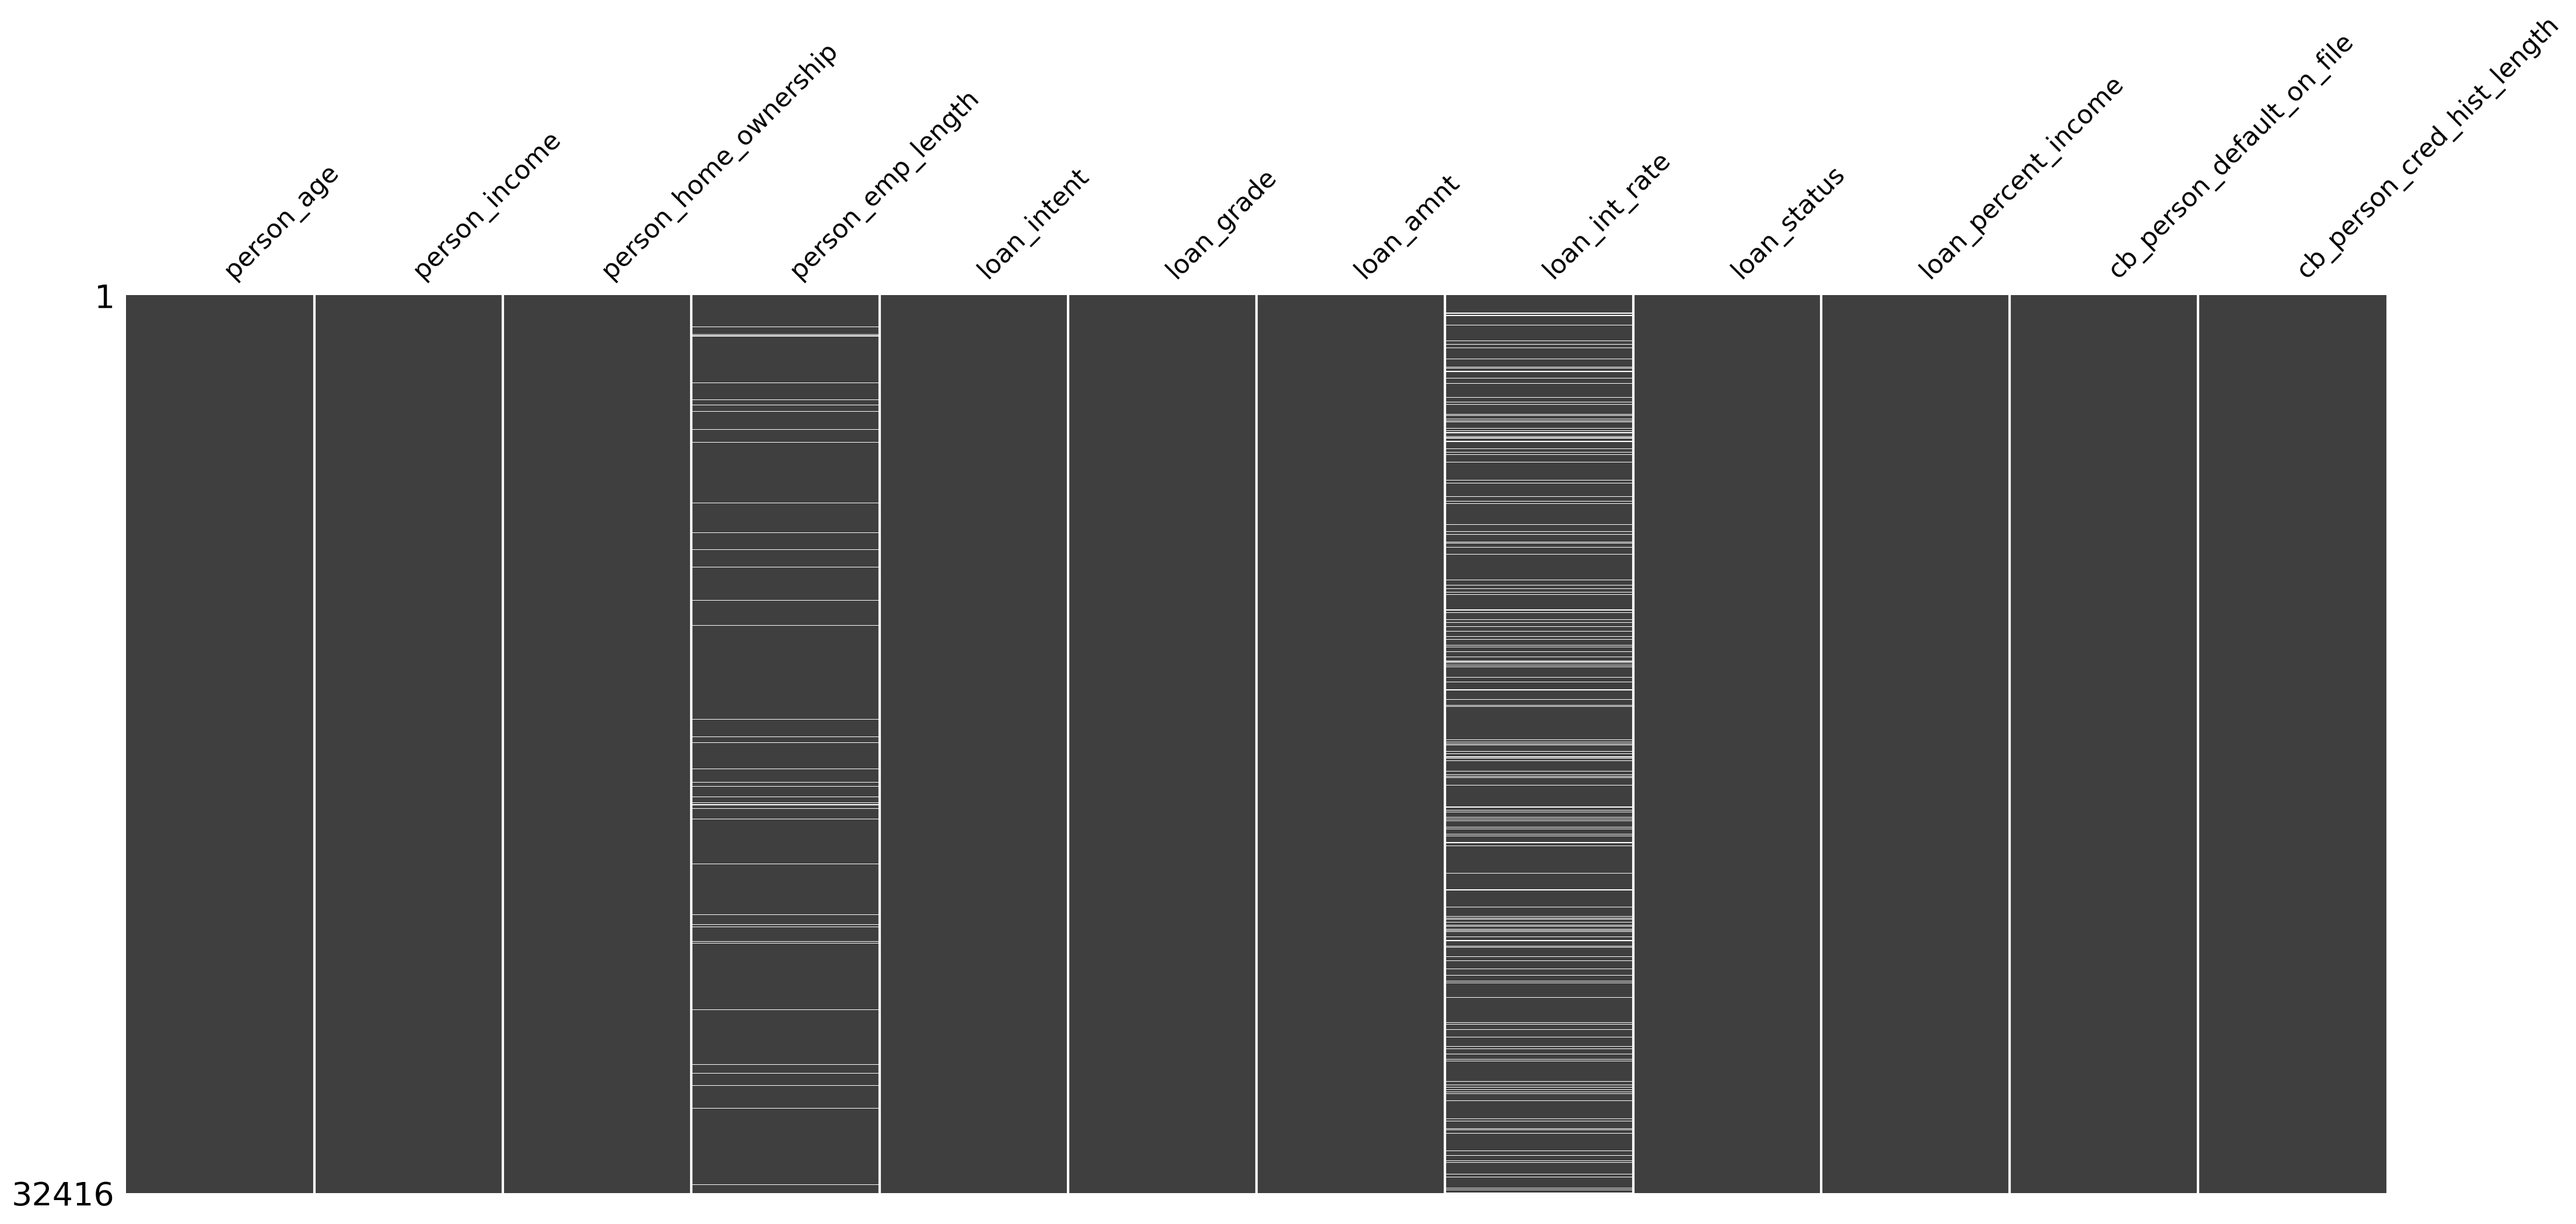

In [10]:
msno.matrix(df_credit, sparkline=False)

In [11]:
df_credit.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [12]:
sum(df_credit.isnull().sum().values) * 100 / df_credit.shape[0]

12.28405725567621

У нас есть выбор:

1.либо удалить эти данные, либо заполнить их каким-нибудь (?) значением. В принципе, т.к. пропущенных данных не много (12%), можно удалить строки.

2.Заполнить в последствии при построении модели: пропуски в колонках person_emp_length (стаж) и loan_int_rate (процентная ставка по кредиту) можно попробоватьзаменить на 0 и медианное значение соответственно.

In [13]:
df_credit.dropna(inplace=True)

In [14]:
df_credit.reset_index(drop=True, inplace=True)

## Обработка аномальных значений

In [15]:
df_credit.describe()

person_age  person_income  person_emp_length     loan_amnt  \
count  28501.000000   2.850100e+04       28501.000000  28501.000000   
mean      27.738676   6.665441e+04           4.790148   9658.533034   
std        6.316166   6.237603e+04           4.157462   6329.604672   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.950000e+04           2.000000   5000.000000   
50%       26.000000   5.600000e+04           4.000000   8000.000000   
75%       30.000000   8.000000e+04           7.000000  12500.000000   
max      144.000000   6.000000e+06         123.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   28501.000000  28501.000000         28501.000000   
mean       11.045385      0.217115             0.169517   
std         3.230748      0.412289             0.106410   
min         5.420000      0.000000             0.000000   
25%         7.900000      0.000000             0.090000   
50%        10.990000      0.000000             0.150000   
75%        13.480000      0.000000             0.230000   
max        23.220000      1.000000             0.830000   

       cb_person_cred_hist_length  
count                28501.000000  
mean                     5.800498  
std                      4.042153  
min                      2.000000  
25%                      3.000000  
50%                      4.000000  
75%                      8.000000  
max                     30.000000


Заметим, что присутствуют аномальные значения: max возраст заемщика = 144 года, max зарплата = 6 млн., max стаж = 123 года. Попробуем обработать это.

In [16]:
df_credit[df_credit['person_age'] == 144]

person_age  person_income person_home_ownership  person_emp_length  \
74            144         250000                  RENT                4.0   
163           144         200000              MORTGAGE                4.0   
28251         144        6000000              MORTGAGE               12.0   

      loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
74        VENTURE          C       4800          13.57            0   
163     EDUCATION          B       6000          11.86            0   
28251    PERSONAL          C       5000          12.73            0   

       loan_percent_income cb_person_default_on_file  \
74                    0.02                         N   
163                   0.03                         N   
28251                 0.00                         N   

       cb_person_cred_hist_length  
74                              3  
163                             2  
28251                          25

Заемщики, которым 144 года, а стаж всего лишь 4 или 12 лет - что-то странное, еще и зарплата последнего - 6 млн., удалим эти строки.

In [17]:
df_credit.drop(df_credit[df_credit['person_age'] >= df_credit['person_age'].max()].index, inplace=True, axis=0)

Также можно удалить из рассмотрения строки с заемщиками, которым более 85 лет, т.к. это максимальный возраст, по которому выдают кредит. Сначала посмотрим на них на всякий случай.

In [18]:
df_credit[df_credit['person_age'] >= 75]

person_age  person_income person_home_ownership  person_emp_length  \
508           123          80004                  RENT                2.0   
28303          78          48000                  RENT               41.0   
28361          80          64000                  RENT                7.0   
28435          84          94800              MORTGAGE                2.0   
28461          76          75000                  RENT               23.0   

      loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
508     EDUCATION          B      20400          10.25            0   
28303     MEDICAL          A       3000           7.51            0   
28361     MEDICAL          B       6800          11.71            0   
28435    PERSONAL          A      10000           7.51            0   
28461     MEDICAL          A      15000           8.94            0   

       loan_percent_income cb_person_default_on_file  \
508                   0.25                         N   
28303                 0.06                         N   
28361                 0.11                         N   
28435                 0.11                         N   
28461                 0.20                         N   

       cb_person_cred_hist_length  
508                             3  
28303                          25  
28361                          25  
28435                          24  
28461                          25

123 года, а стаж от 2 года - удалим эту строку, она нам не понадобится.

In [19]:
df_credit.drop(df_credit[df_credit['person_age'] >= 75].index, inplace=True, axis=0)

Посмотрим на статистику.

In [20]:
df_credit.describe()

person_age  person_income  person_emp_length     loan_amnt  \
count  28493.000000   2.849300e+04       28493.000000  28493.000000   
mean      27.715825   6.643406e+04           4.788158   9658.753027   
std        6.146996   5.152052e+04           4.150794   6329.785667   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.948000e+04           2.000000   5000.000000   
50%       26.000000   5.600000e+04           4.000000   8000.000000   
75%       30.000000   8.000000e+04           7.000000  12500.000000   
max       73.000000   2.039784e+06         123.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   28493.000000  28493.000000         28493.000000   
mean       11.045535      0.217176             0.169537   
std         3.230982      0.412331             0.106409   
min         5.420000      0.000000             0.000000   
25%         7.900000      0.000000             0.090000   
50%        10.990000      0.000000             0.150000   
75%        13.480000      0.000000             0.230000   
max        23.220000      1.000000             0.830000   

       cb_person_cred_hist_length  
count                28493.000000  
mean                     5.797494  
std                      4.034743  
min                      2.000000  
25%                      3.000000  
50%                      4.000000  
75%                      8.000000  
max                     30.000000

Мы заметили также аномально большой стаж = 123 года, при удалении строк с возрастом он так и остался, несмотря на то, что максимальный возраст = 84 года. Посмотрим на строки, соответствующие этой ошибке.

In [21]:
df_credit[df_credit['person_emp_length'] > df_credit['person_age']]

person_age  person_income person_home_ownership  person_emp_length  \
0            22          59000                  RENT              123.0   
186          21         192000              MORTGAGE              123.0   

    loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0      PERSONAL          D      35000          16.02            1   
186     VENTURE          A      20000           6.54            0   

     loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                   0.59                         Y                           3  
186                 0.10                         N                           4

Возраст 22 и 21, а стаж 123 года - явно выбросы, удалим их.

In [22]:
df_credit.drop(df_credit[df_credit.person_emp_length>df_credit.person_age].index, inplace=True, axis=0)

Посмотрим на статистику. Сейчас все должно быть нормально относительно возраста и стажа.

In [23]:
df_credit.describe()

person_age  person_income  person_emp_length     loan_amnt  \
count  28491.000000   2.849100e+04       28491.000000  28491.000000   
mean      27.716261   6.642991e+04           4.779860   9657.500614   
std        6.146989   5.151694e+04           4.031037   6327.930430   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.948000e+04           2.000000   5000.000000   
50%       26.000000   5.599200e+04           4.000000   8000.000000   
75%       30.000000   8.000000e+04           7.000000  12500.000000   
max       73.000000   2.039784e+06          38.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   28491.000000  28491.000000         28491.000000   
mean       11.045519      0.217156             0.169524   
std         3.230851      0.412317             0.106383   
min         5.420000      0.000000             0.000000   
25%         7.900000      0.000000             0.090000   
50%        10.990000      0.000000             0.150000   
75%        13.480000      0.000000             0.230000   
max        23.220000      1.000000             0.830000   

       cb_person_cred_hist_length  
count                28491.000000  
mean                     5.797655  
std                      4.034836  
min                      2.000000  
25%                      3.000000  
50%                      4.000000  
75%                      8.000000  
max                     30.000000

Видно, что имеются слишком большие значения в колонке person_income, выведем 10 самых больших.

In [24]:
df_credit['person_income'].nlargest(10)

26292    2039784
28427    1782000
27937    1440000
27935    1362000
15582    1200000
25493    1200000
15583     948000
25494     900000
27934     900000
28252     900000
Name: person_income, dtype: int64

Посмотрим на клиентов, чья зарплата больше 900 тысяч и проанализируем ситуацию.

In [25]:
df_credit[df_credit['person_income'] > 900000]

person_age  person_income person_home_ownership  person_emp_length  \
15582          32        1200000              MORTGAGE                1.0   
15583          34         948000              MORTGAGE               18.0   
25493          36        1200000                   OWN               16.0   
26292          42        2039784                  RENT                0.0   
27935          47        1362000              MORTGAGE                9.0   
27937          44        1440000              MORTGAGE                7.0   
28427          63        1782000                  RENT               13.0   

             loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
15582            VENTURE          A      12000           7.51            0   
15583           PERSONAL          B       2000           9.99            0   
25493            MEDICAL          A      10000           6.54            0   
26292            VENTURE          C       8450          12.29            0   
27935            VENTURE          A       6600           7.74            0   
27937  DEBTCONSOLIDATION          A       6400           7.40            0   
28427          EDUCATION          C      12025          14.27            0   

       loan_percent_income cb_person_default_on_file  \
15582                 0.01                         N   
15583                 0.00                         N   
25493                 0.01                         N   
26292                 0.00                         Y   
27935                 0.00                         N   
27937                 0.00                         N   
28427                 0.01                         N   

       cb_person_cred_hist_length  
15582                           8  
15583                           7  
25493                          11  
26292                          15  
27935                          17  
27937                          15  
28427                          30

In [26]:
df_credit.drop(df_credit[df_credit['person_income'] == df_credit['person_income'].max()].index, inplace=True, axis=0)

Данные значения очень высокого дохода носят объективный характер: возраст у клиентов выше 30, в основном - большой стаж (более 7 лет), средний уровень кредитоспособности и отсутствие дефолтов в прошлом. Клиенты с маленьким стажем из категории получающих большую зарплату берут кредит на развитие предприятия. После разделения на обучающую и тестовую выборку необходимо будет прологарифмировать столбец person_income.

## Анализ категориальных признаков

Посмотрим на кол-во уникальных значений каждой переменной.

In [27]:
df_credit.select_dtypes(include='object').describe()

person_home_ownership loan_intent loan_grade cb_person_default_on_file
count                  28490       28490      28490                     28490
unique                     4           6          7                         2
top                     RENT   EDUCATION          A                         N
freq                   14491        5668       9341                     23402

Переменных с кол-вом уникальных значений, совпадающих с кол-вом наблюдений нет, переменных с одним уникальным значением тоже нет - все хорошо.

Разделим количественные переменные и категориальные для дальнейшего анализа.

In [28]:
def get_typed_data(df, target):
    num_cols = []
    cat_cols = []
    for i in df.columns.drop(target):
        if is_numeric_dtype(df[i]):
            num_cols.append(i)
        else:
            cat_cols.append(i)
    return num_cols, cat_cols

In [29]:
TARGET = 'loan_status'
FACTORS_NUM, FACTORS_CAT = get_typed_data(df_credit, TARGET)

In [30]:
FACTORS_CAT_ORDINAL = ['loan_grade']
FACTORS_CAT_C = FACTORS_CAT.copy()
FACTORS_CAT_C.remove(FACTORS_CAT_ORDINAL[0])
FACTORS_CAT_NOMINAL = FACTORS_CAT_C

Посмотрим на всевозможные значения категориальных переменных.

In [31]:
for col in FACTORS_CAT:
    print(col, df_credit[col].unique())

person_home_ownership ['OWN' 'MORTGAGE' 'RENT' 'OTHER']
loan_intent ['EDUCATION' 'MEDICAL' 'VENTURE' 'PERSONAL' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
loan_grade ['B' 'C' 'A' 'D' 'E' 'F' 'G']
cb_person_default_on_file ['N' 'Y']


Выведем частоты различных категорий всех признаков выше.

In [32]:
for col in FACTORS_CAT:
    print(df_credit[col].value_counts())
    print('')

RENT        14491
MORTGAGE    11732
OWN          2174
OTHER          93
Name: person_home_ownership, dtype: int64

EDUCATION            5668
MEDICAL              5266
VENTURE              4966
PERSONAL             4856
DEBTCONSOLIDATION    4547
HOMEIMPROVEMENT      3187
Name: loan_intent, dtype: int64

A    9341
B    9091
C    5679
D    3242
E     869
F     209
G      59
Name: loan_grade, dtype: int64

N    23402
Y     5088
Name: cb_person_default_on_file, dtype: int64



Посмотрим на частоты категорий.

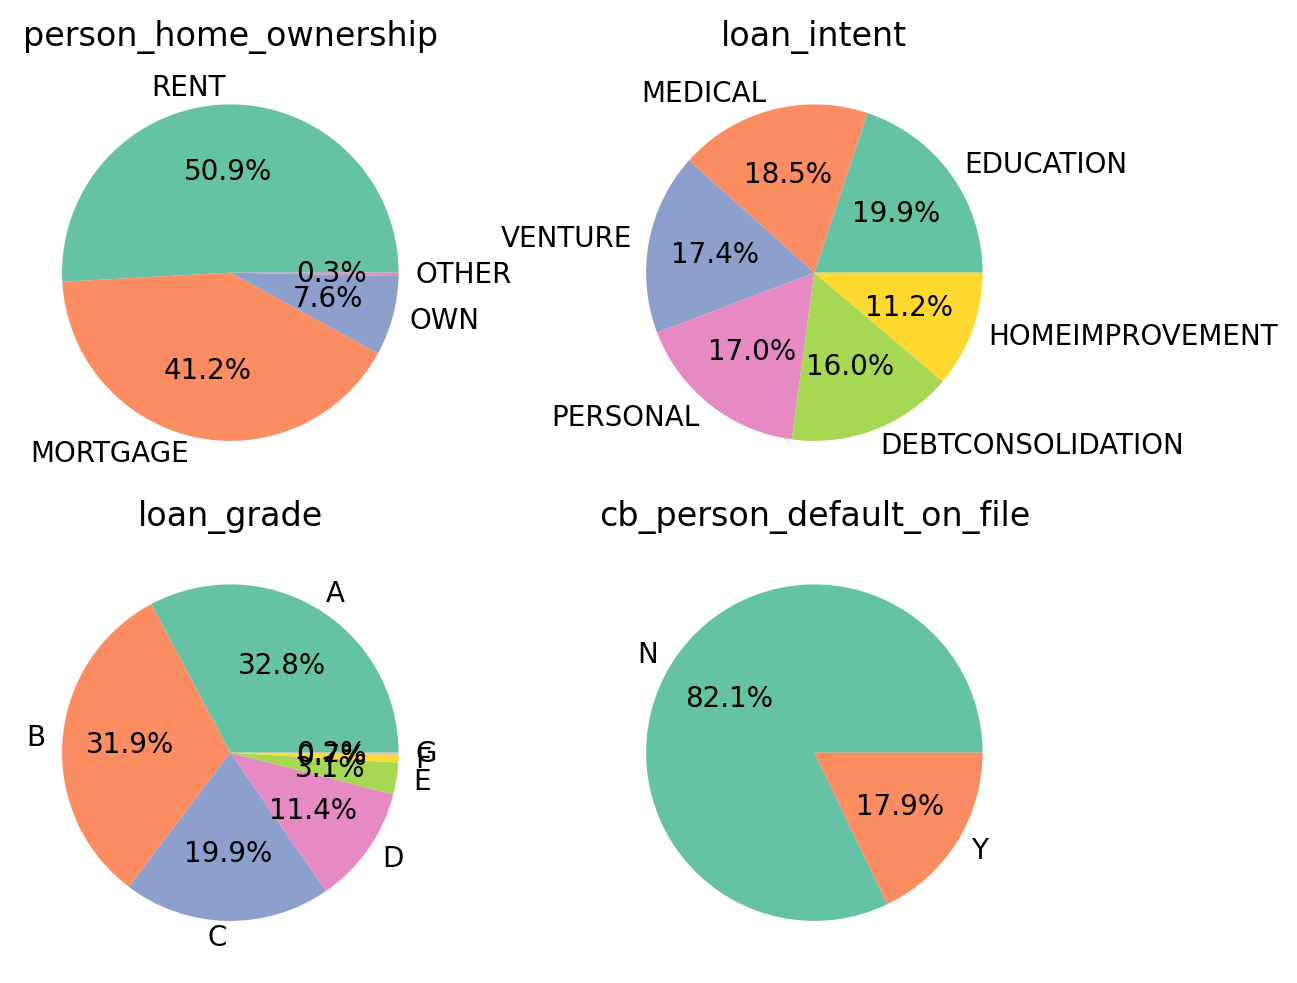

In [33]:
fig, axs = plt.subplots(2, 2)
axs = axs.ravel()
palette_color = sns.color_palette("Set2")
for i, cat_fct in enumerate(df_credit[FACTORS_CAT]):
    df_credit[cat_fct].value_counts().plot(kind="pie", colors=palette_color, ax=axs[i], autopct='%1.1f%%', ylabel='', title=cat_fct)
plt.show()

In [34]:
def contigency_table(column):
    crosstable1 = pd.crosstab(df_credit[column], df_credit['loan_status']).reset_index()
    crosstable2 = pd.crosstab(df_credit[column], df_credit['loan_status']).apply(lambda r: round(r / r.sum() * 100, 2), axis=1).reset_index()
    crosstable = pd.merge(crosstable1, crosstable2, how='inner', on=column).set_index(column)
    crosstable.columns = ['Non-default', 'Default', '%Non-default', '%Default']
    return crosstable

In [35]:
def bar_graphs(data, ax):
    N = data.shape[0]
    default_bar = list(data['%Default'])
    nondefault_bar = list(data['%Non-default'])
    ind = np.arange(N)
    plt.figure(figsize=(10,5))
    width = 0.3       
    ax.bar(ind, default_bar , width, label='%Default')
    ax.bar(ind + width, nondefault_bar, width, label='%Non-default')
    ax.set_xlabel(f"{data.index.name}")
    ax.set_ylabel('Percentages')
    ax.set_xticks(ind + width / 2, list(data.index))
    ax.legend(loc='best')

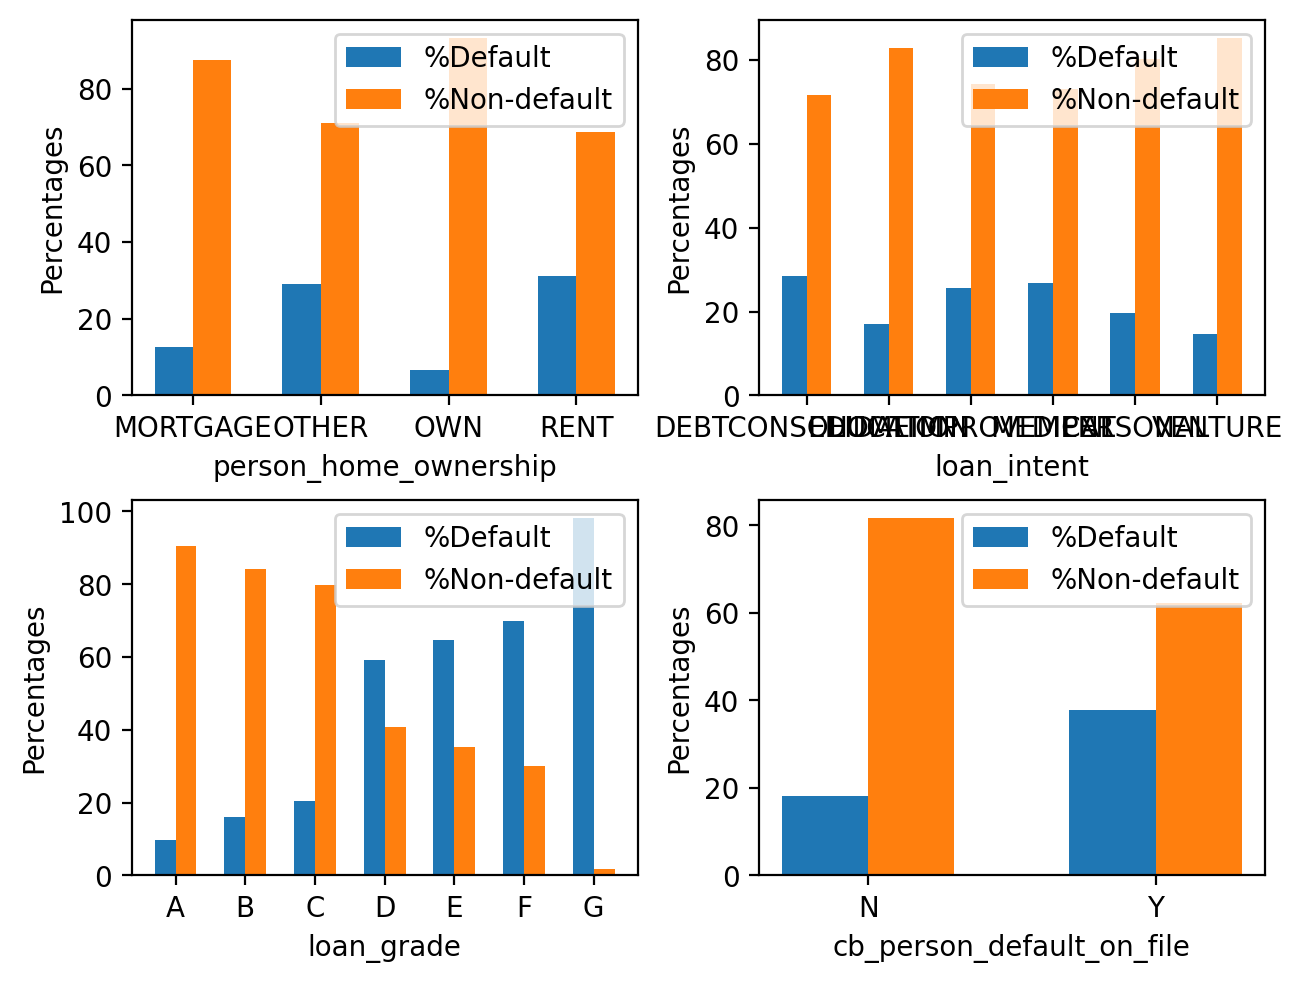

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [36]:
fig, axs = plt.subplots(2, 2)
axs = axs.ravel()
for i, cat_fct in enumerate(df_credit[FACTORS_CAT]):
    bar_graphs(contigency_table(cat_fct), ax=axs[i])
plt.show()

## Анализ распределения количественных признаков

Посмотрим на распределения количественных признаков. Видно, что мы не зря хотим прологарифмировать колонку person_income, т.к. после преобразования распределение этой колонки будет нормальным.

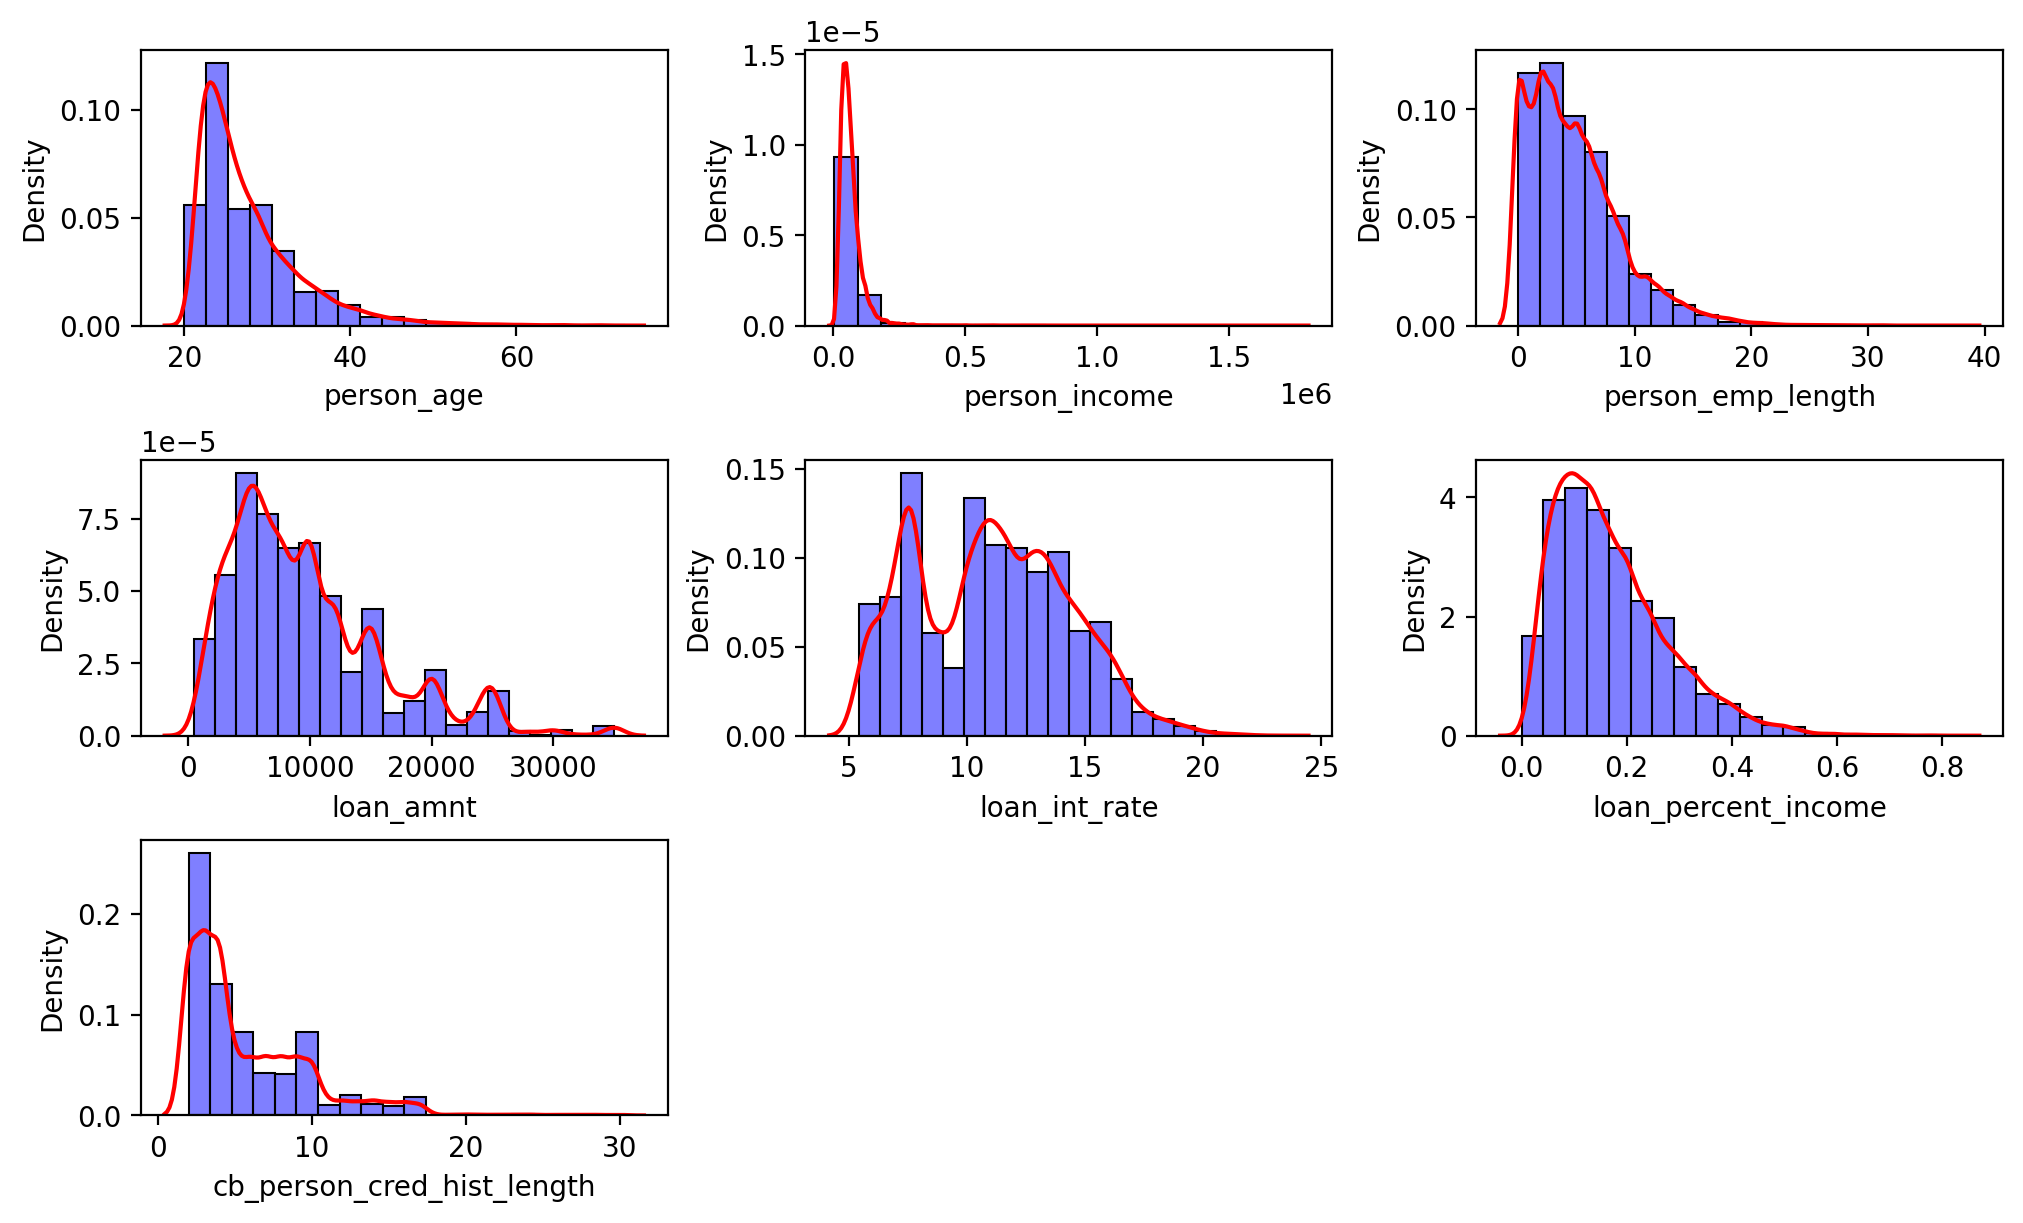

In [37]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 6))
axes = axes.ravel()
cols = FACTORS_NUM

for col, ax in zip(cols, axes):
    sns.histplot(data=df_credit[col], ax=ax, color='blue', stat='density', bins=20, alpha=0.5)
    sns.kdeplot(data=df_credit[col], ax=ax, color='red')
    
fig.delaxes(axes[7])
fig.delaxes(axes[8])
fig.tight_layout()
plt.show()

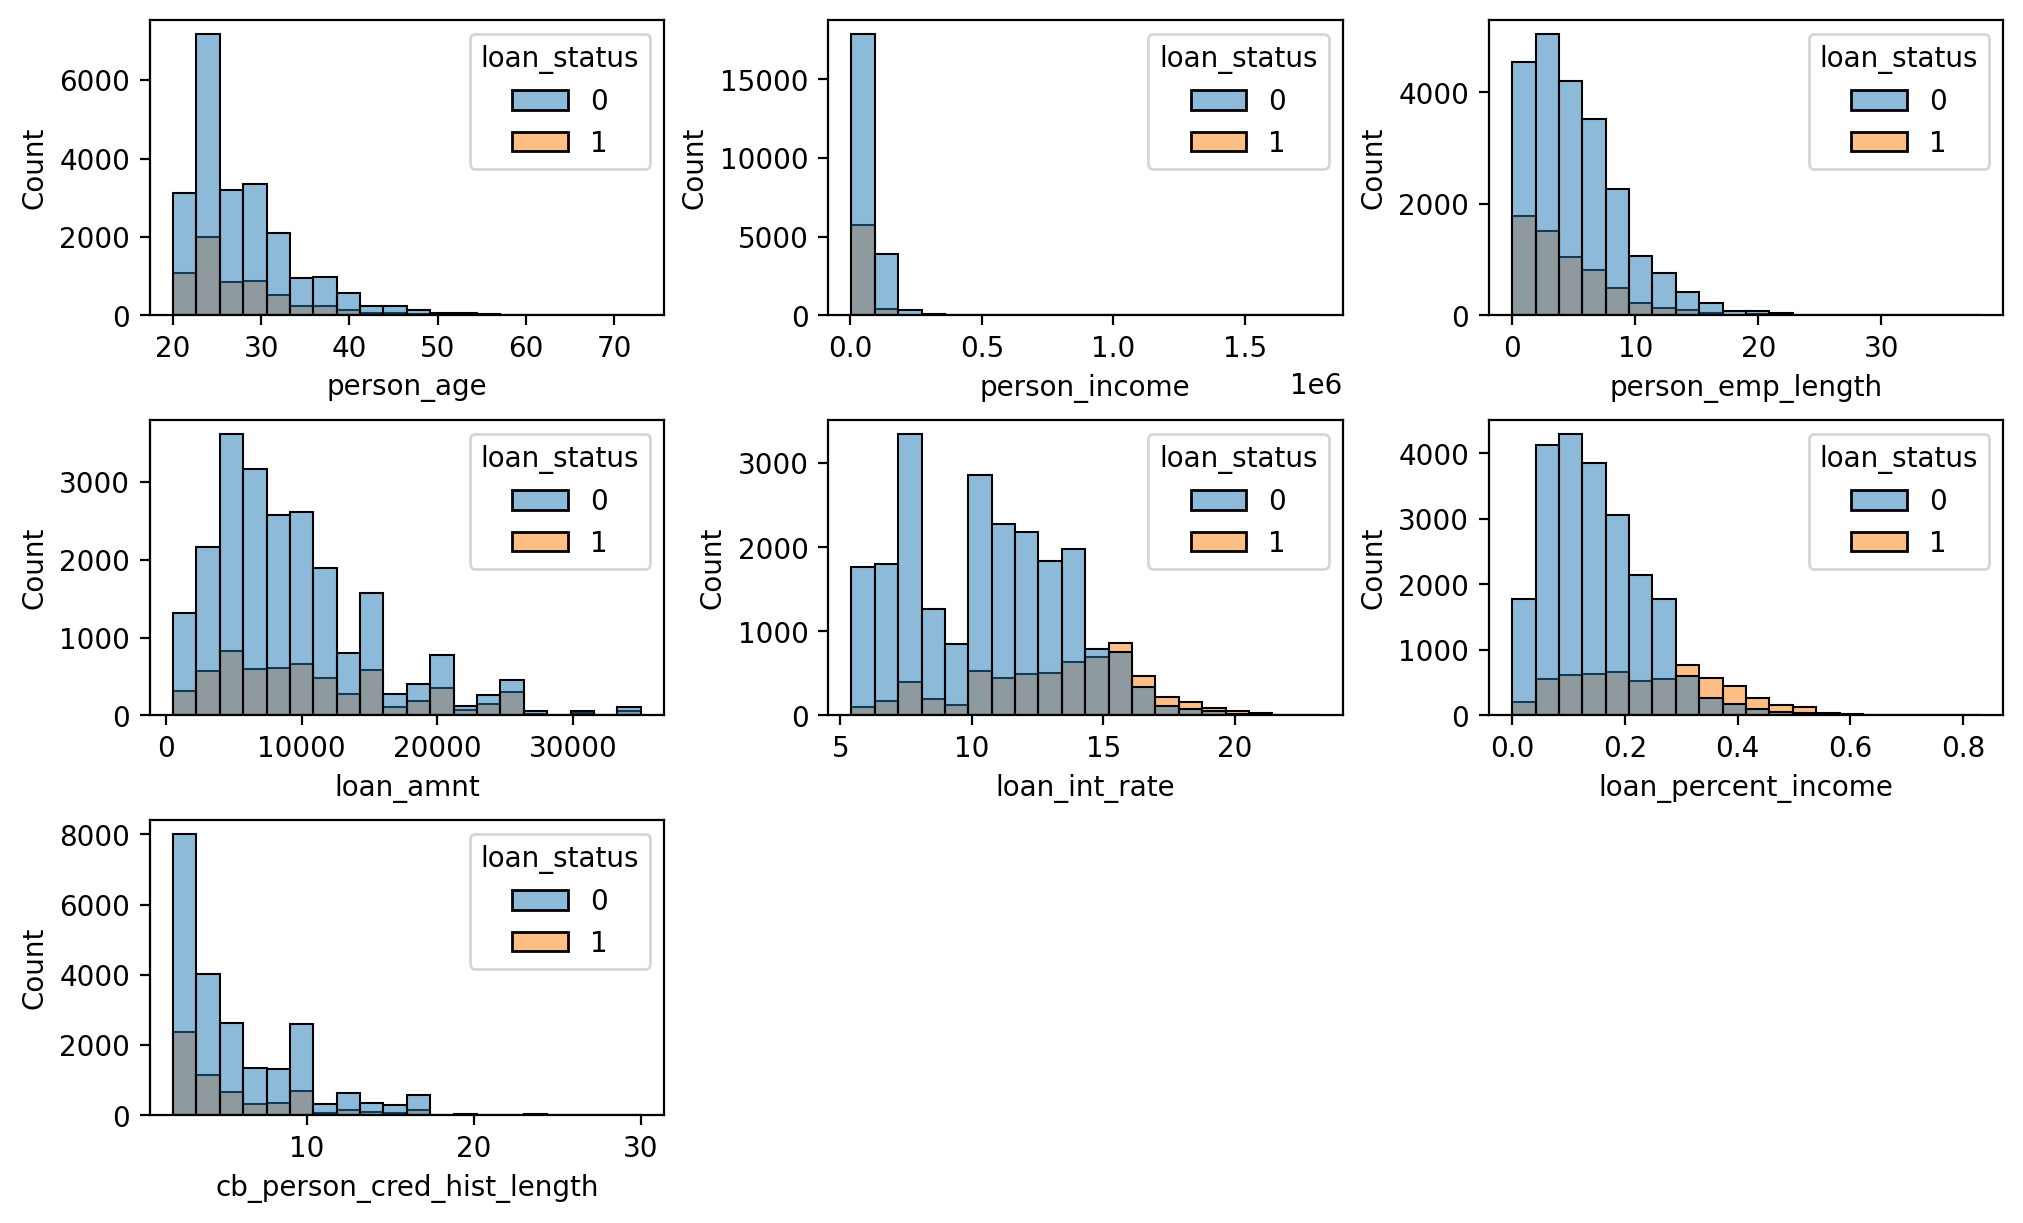

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 6))
axes = axes.ravel()
cols = FACTORS_NUM

for col, ax in zip(cols, axes):
    sns.histplot(x=col, hue = 'loan_status', data = df_credit, ax=ax, bins=20)
    
fig.delaxes(axes[7])
fig.delaxes(axes[8])
fig.tight_layout()
plt.show()


## Отбор признаков для дальнейшего обучения модели

Выведем матрицу корреляций количественных признаков.

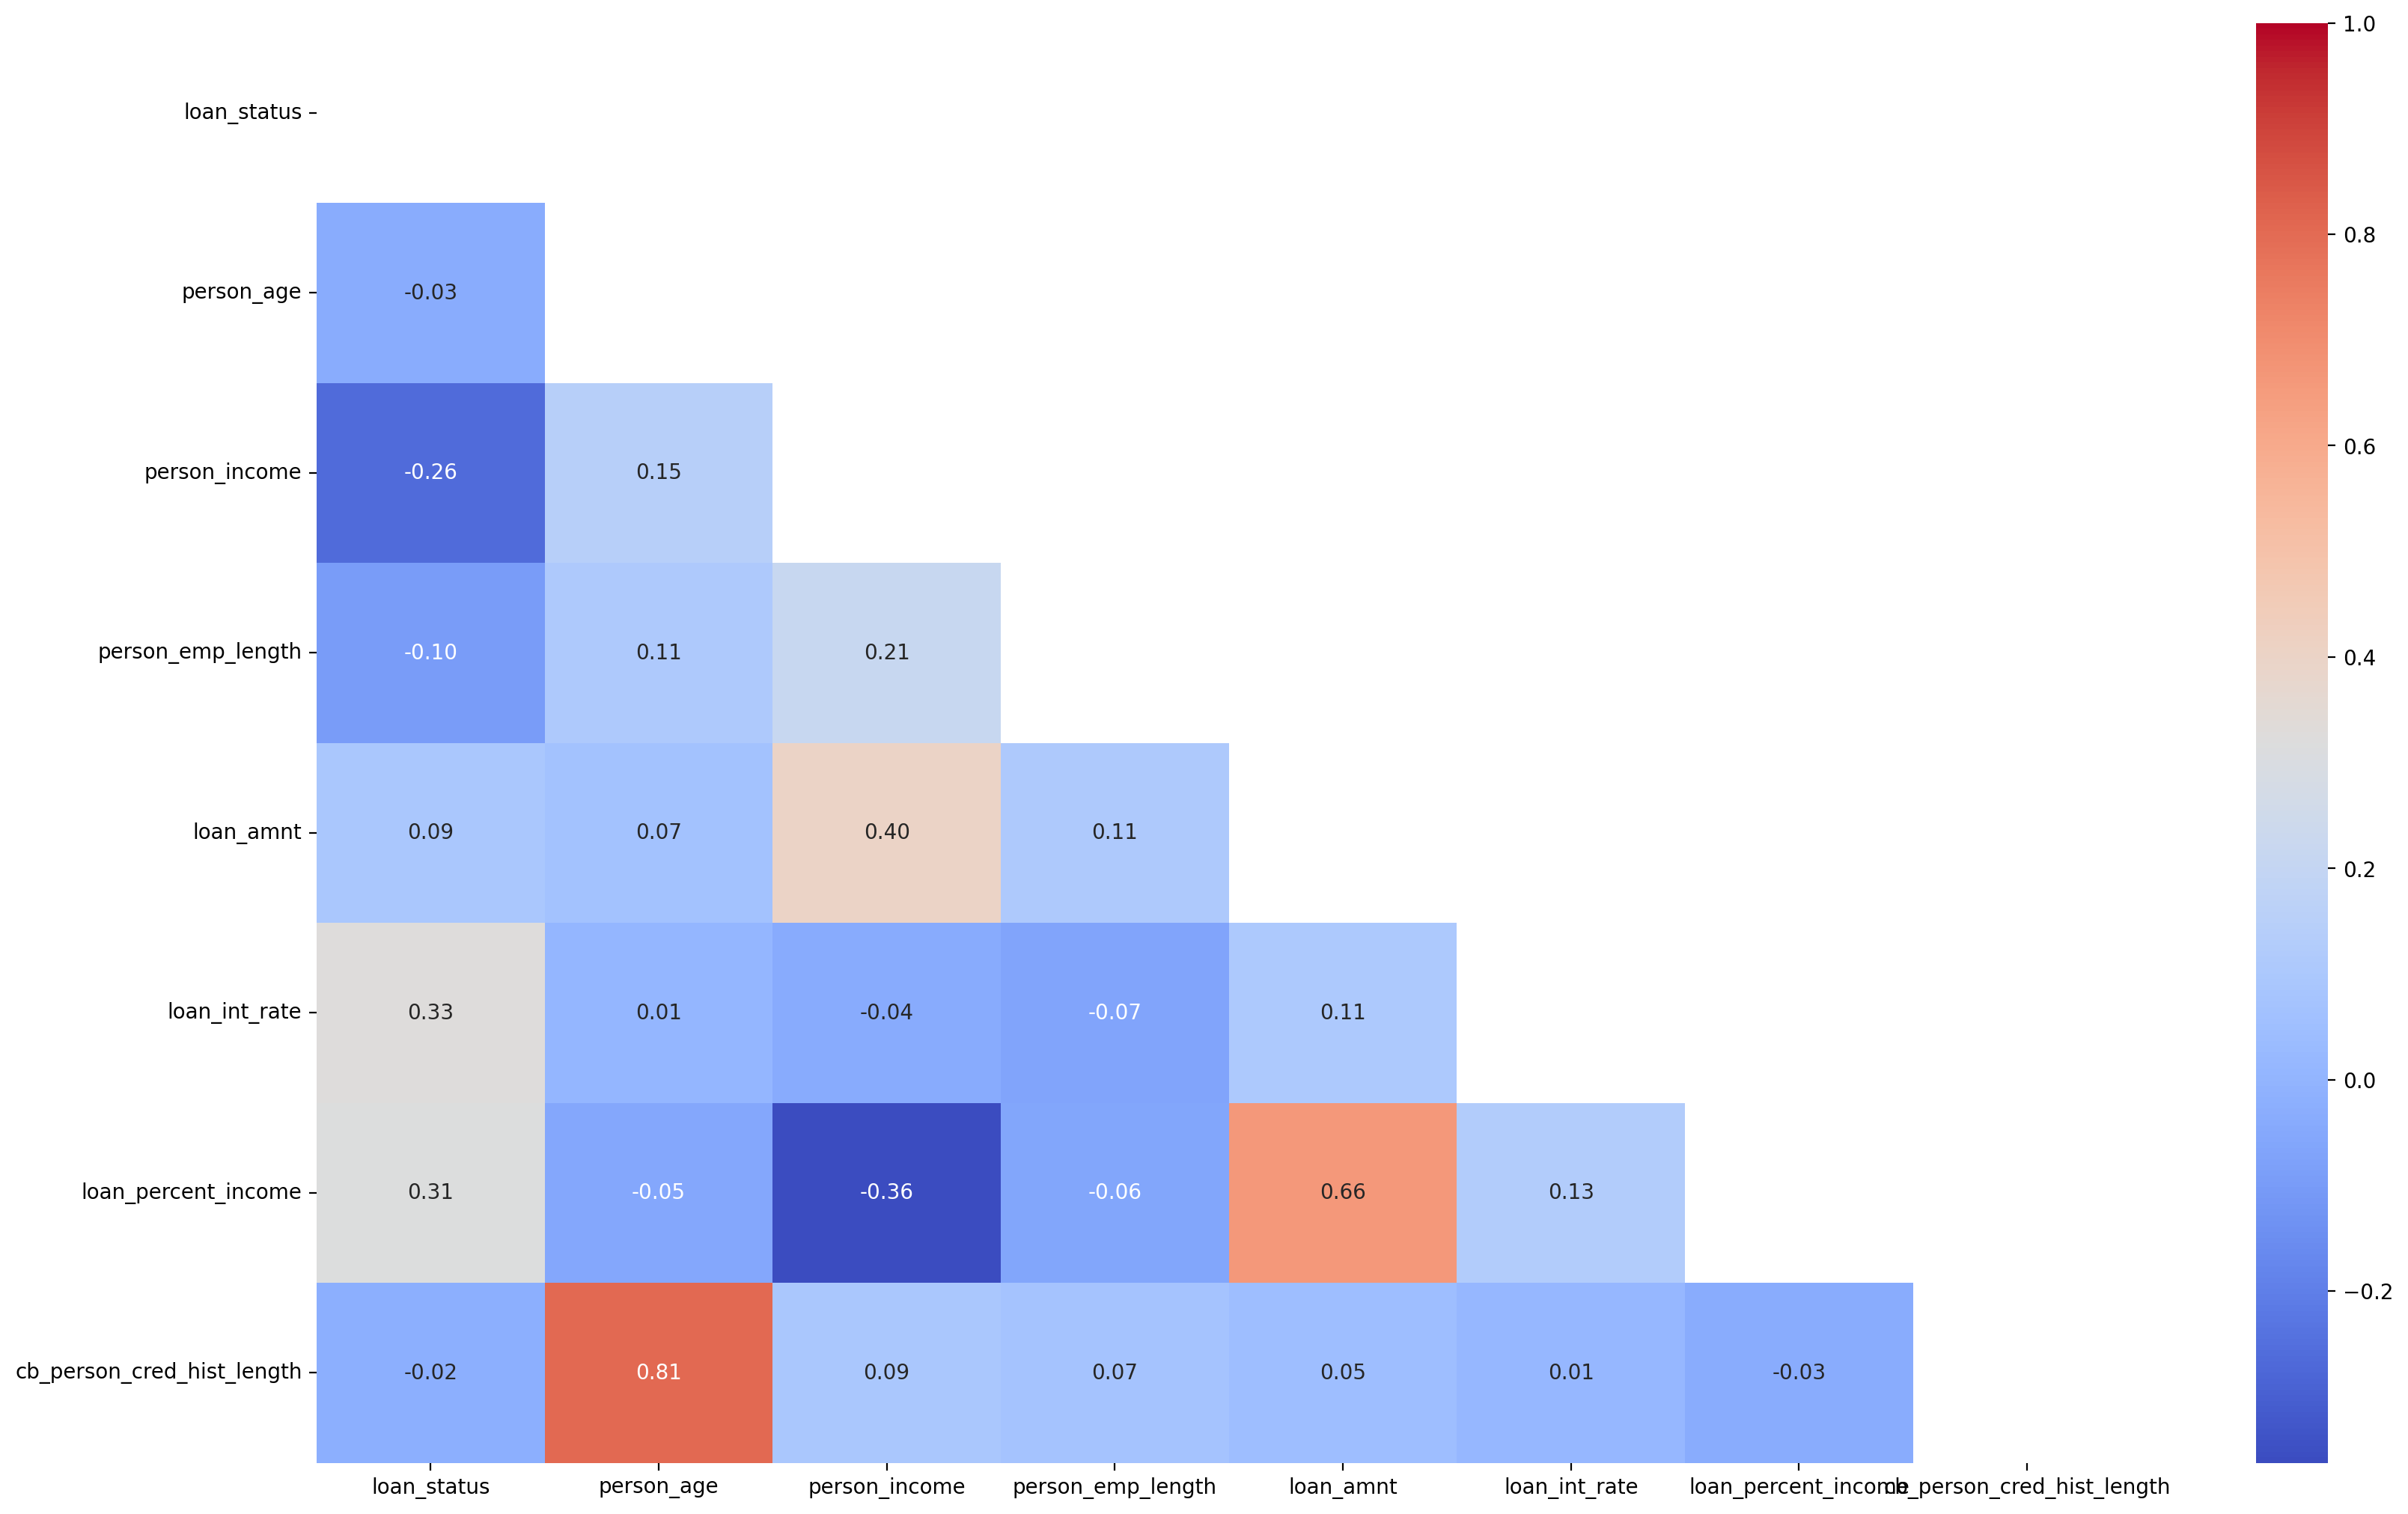

In [39]:
corr = df_credit[[TARGET]+FACTORS_NUM].corr(method='spearman')
mask = np.triu(corr)
f, ax = plt.subplots(figsize=(16, 10))
ax = sns.heatmap(corr, mask=mask, vmin=corr.values.ravel().min(), 
                 vmax=corr.values.ravel().max(), 
                 annot=True, fmt='.2f', cmap='coolwarm')

c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\seaborn\axisgrid.py:208: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.


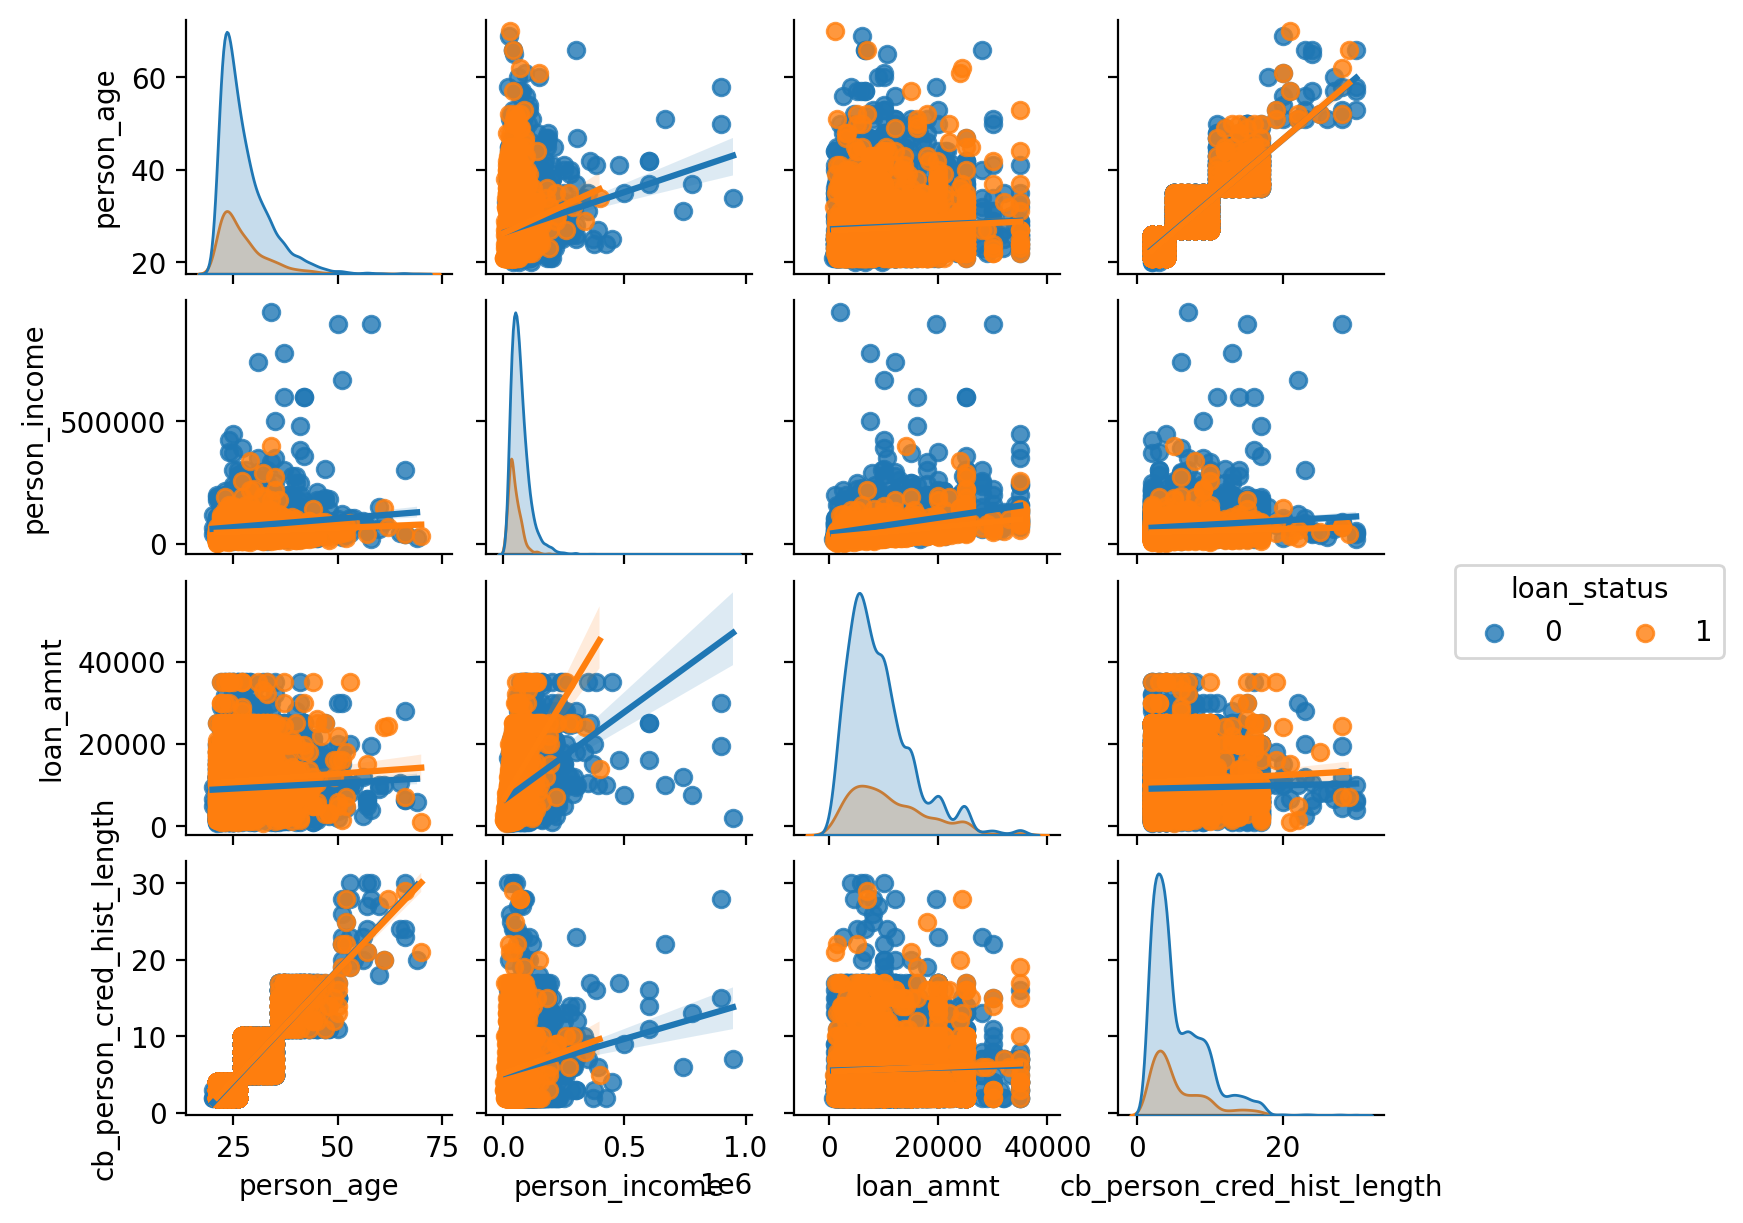

In [40]:
g = sns.pairplot(df_credit[['loan_status', 'person_age', 'person_income', 'loan_amnt', 'cb_person_cred_hist_length']].sample(frac=0.2, random_state=42), kind="reg", hue="loan_status", height=1.5)
sns.move_legend(g, "center right", bbox_to_anchor=(1.25, 0.5), ncol=3, frameon=True)

У переменных person_age и cb_person_cred_hist_length значительная положительная корреляция: чем старше человек, тем больше его кредитная история. Необходимо как-то обработать эту зависимость факторов, чтобы избежать проблем.


1. С помощью отбора признаков

In [41]:
vif = pd.DataFrame()
c_df_credit = sm.add_constant(df_credit[FACTORS_NUM])
vif["features"] = c_df_credit.columns
vif["VIF Factor"] = [variance_inflation_factor(c_df_credit.values, i) for i in range(c_df_credit.shape[1])]
print(vif)

                     features  VIF Factor
0                       const   65.820301
1                  person_age    4.412511
2               person_income    1.946730
3           person_emp_length    1.069070
4                   loan_amnt    2.671429
5               loan_int_rate    1.030575
6         loan_percent_income    2.583432
7  cb_person_cred_hist_length    4.363880


In [42]:
for i in FACTORS_NUM:
    X = df_credit[FACTORS_NUM].drop(i, axis=1)
    X = sm.add_constant(X)
    y = df_credit[i]
    model = sm.OLS(y, X)
    results = model.fit()
    print(i, " VIF: ", 1/(1-results.rsquared))

person_age  VIF:  4.412511425093474
person_income  VIF:  1.9467296852798759
person_emp_length  VIF:  1.0690699088684552
loan_amnt  VIF:  2.6714286034328523
loan_int_rate  VIF:  1.0305749007328993
loan_percent_income  VIF:  2.5834320884269157
cb_person_cred_hist_length  VIF:  4.363880160244046


In [43]:
df_credit.drop('person_age', axis=1, inplace=True)

In [44]:
FACTORS_NUM.remove('person_age')

In [45]:
for i in FACTORS_NUM:
    X = df_credit[FACTORS_NUM].drop(i, axis=1)
    X = sm.add_constant(X)
    y = df_credit[i]
    model = sm.OLS(y, X)
    results = model.fit()
    print(i, " VIF: ", 1/(1-results.rsquared))

person_income  VIF:  1.9444438837622848
person_emp_length  VIF:  1.0629343306714454
loan_amnt  VIF:  2.6708325950108898
loan_int_rate  VIF:  1.0305723719293816
loan_percent_income  VIF:  2.58290440663129
cb_person_cred_hist_length  VIF:  1.034340749079722


In [46]:
vif = pd.DataFrame()
c_df_credit = sm.add_constant(df_credit[FACTORS_NUM])
vif["features"] = c_df_credit.columns
vif["VIF Factor"] = [variance_inflation_factor(c_df_credit.values, i) for i in range(c_df_credit.shape[1])]
print(vif)

                     features  VIF Factor
0                       const   20.946345
1               person_income    1.944444
2           person_emp_length    1.062934
3                   loan_amnt    2.670833
4               loan_int_rate    1.030572
5         loan_percent_income    2.582904
6  cb_person_cred_hist_length    1.034341


---------------------------------------------------------------------------------------------------

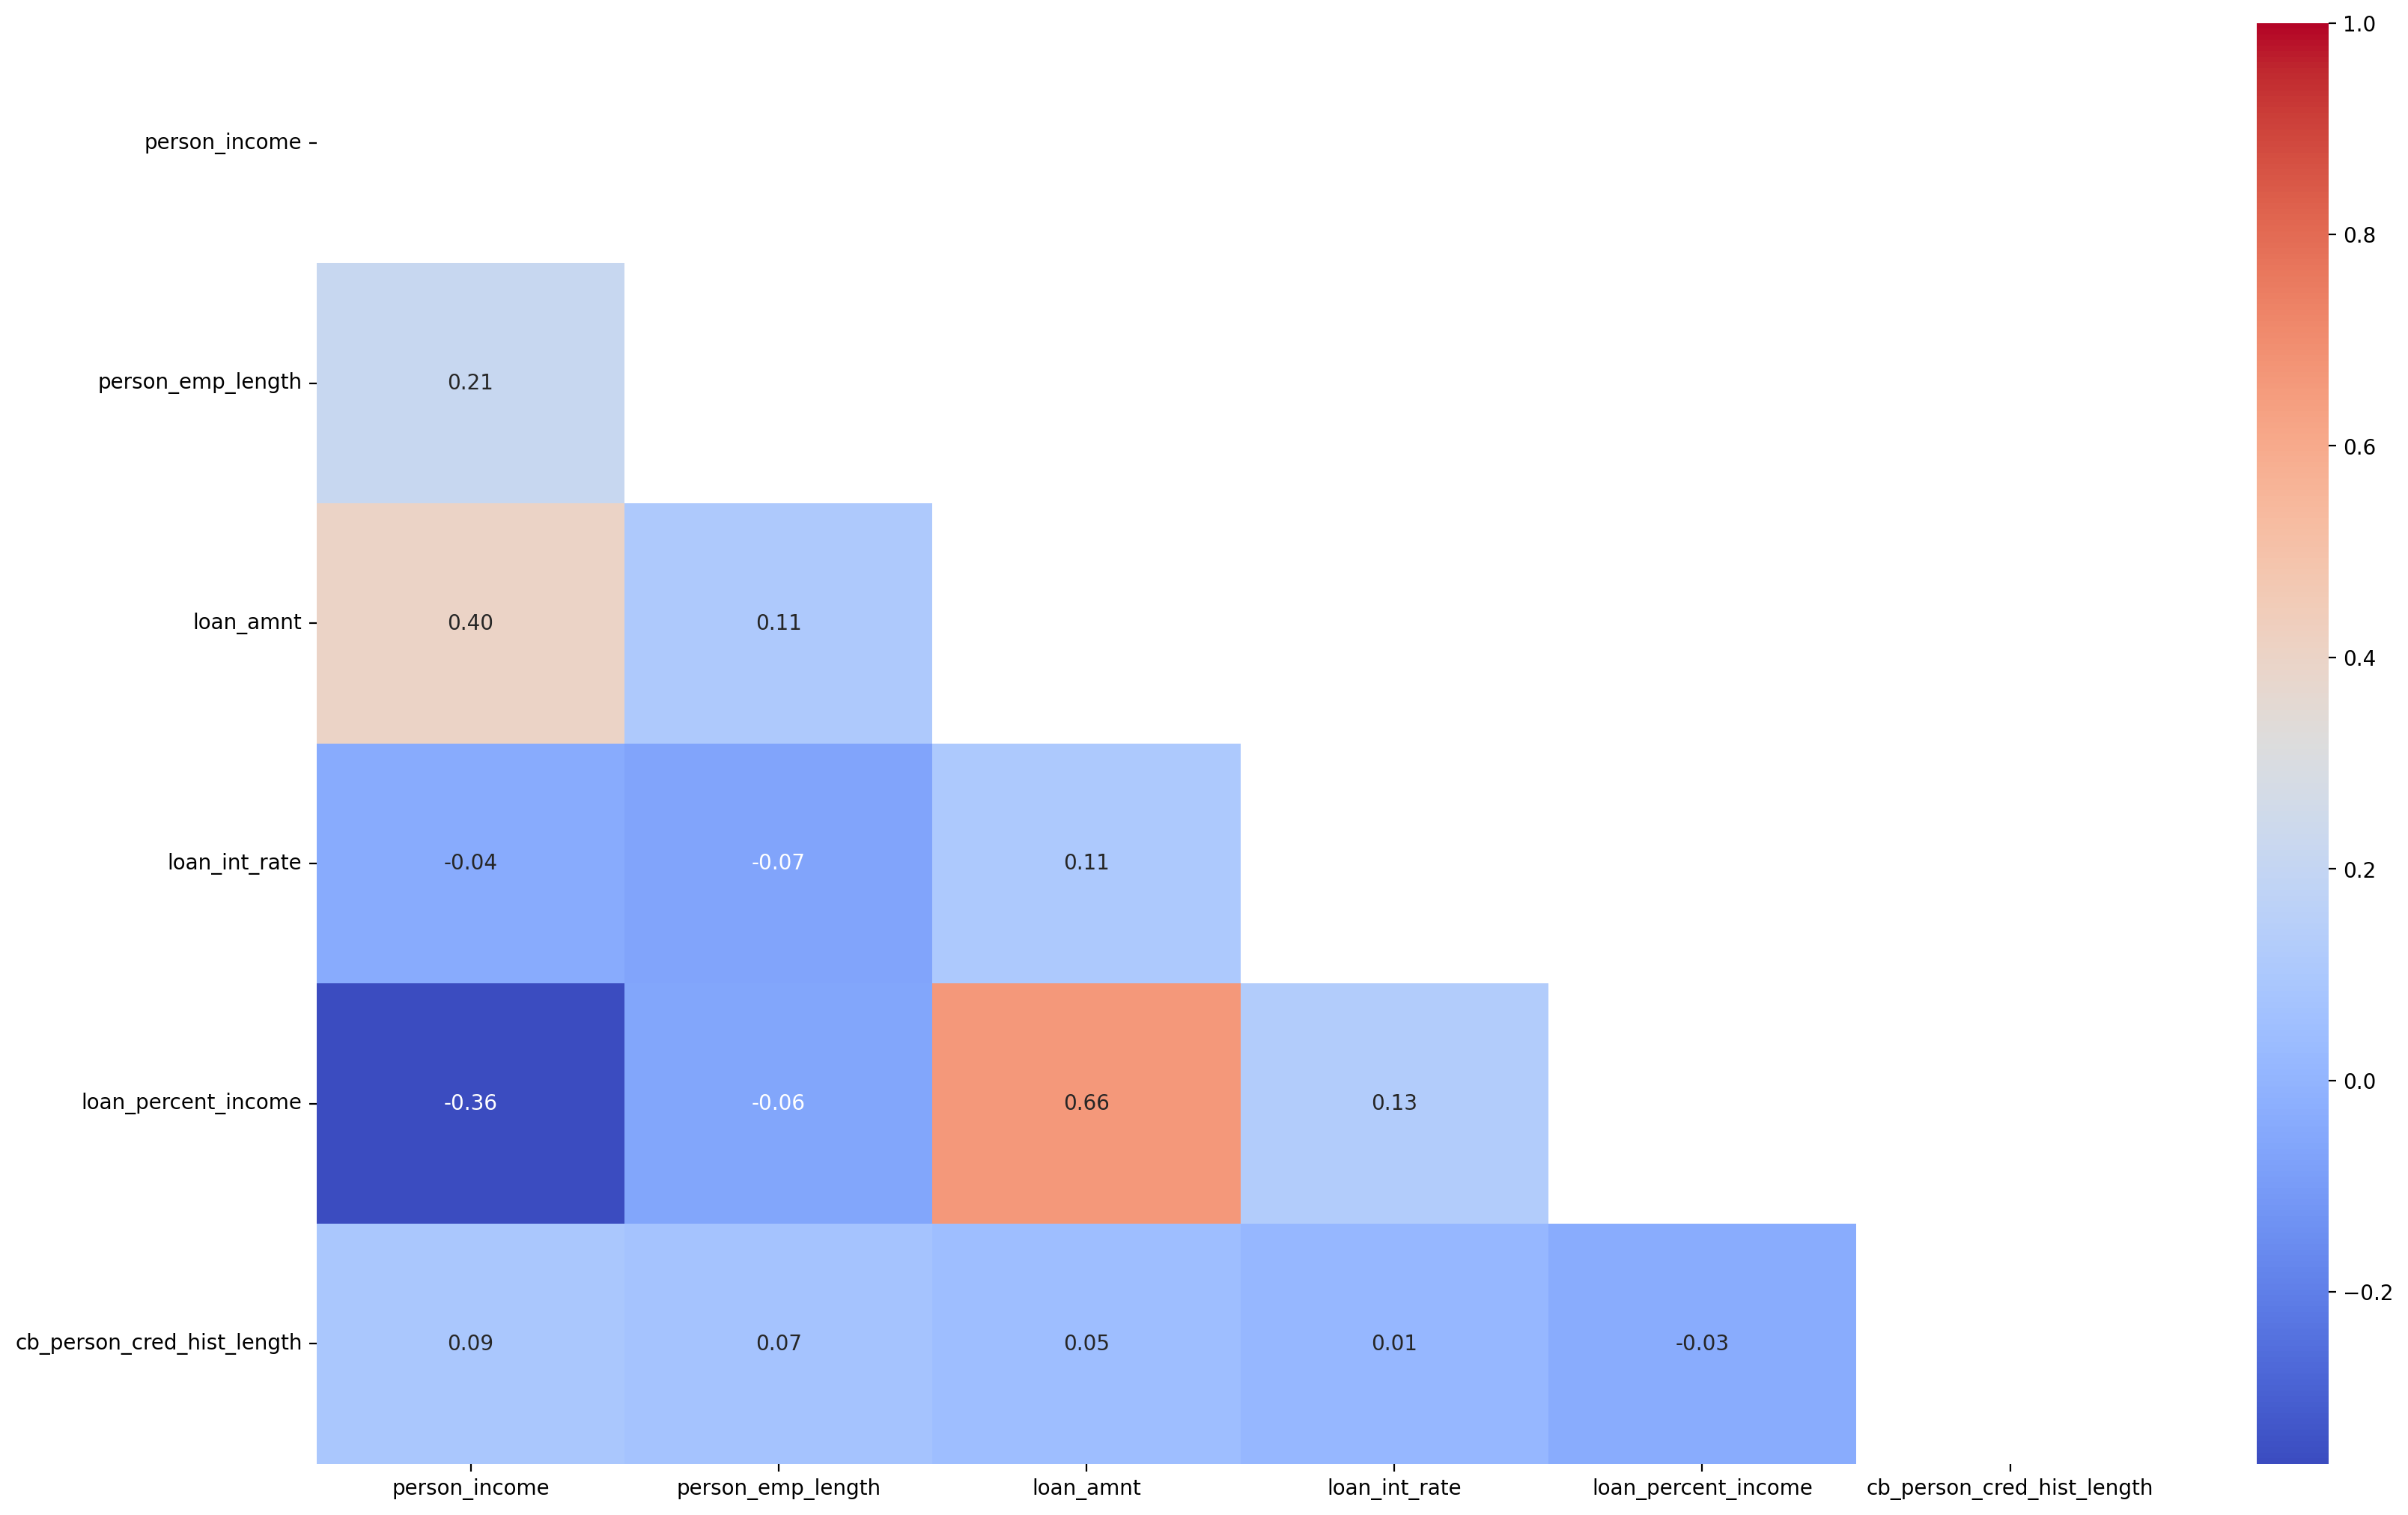

In [47]:
corr = df_credit[FACTORS_NUM].corr(method='spearman')
mask = np.triu(corr)
f, ax = plt.subplots(figsize=(16, 10))
ax = sns.heatmap(corr, mask=mask, vmin=corr.values.ravel().min(), 
                 vmax=corr.values.ravel().max(), 
                 annot=True, fmt='.2f', cmap='coolwarm')

Применим дамми-кодирование к номинальным признакам и порядковое кодирование к порядковым - превратим колонку в несколько колонок по кол-ву признаков, значение которой будет индикатором в 1 случае, а во 2 каждому классу присвоим цифру.

In [48]:
df_credit = pd.get_dummies(df_credit, columns=FACTORS_CAT_NOMINAL, drop_first=True)

In [49]:
encoder = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
df_credit['loan_grade'] = df_credit['loan_grade'].map(encoder)

In [50]:
df_credit.head()

person_income  person_emp_length  loan_grade  loan_amnt  loan_int_rate  \
1           9600                5.0           1       1000          11.14   
2           9600                1.0           2       5500          12.87   
3          65500                4.0           2      35000          15.23   
4          54400                8.0           2      35000          14.27   
5           9900                2.0           0       2500           7.14   

   loan_status  loan_percent_income  cb_person_cred_hist_length  \
1            0                 0.10                           2   
2            1                 0.57                           3   
3            1                 0.53                           2   
4            1                 0.55                           4   
5            1                 0.25                           2   

   person_home_ownership_OTHER  person_home_ownership_OWN  \
1                            0                          1   
2                            0                          0   
3                            0                          0   
4                            0                          0   
5                            0                          1   

   person_home_ownership_RENT  loan_intent_EDUCATION  \
1                           0                      1   
2                           0                      0   
3                           1                      0   
4                           1                      0   
5                           0                      0   

   loan_intent_HOMEIMPROVEMENT  loan_intent_MEDICAL  loan_intent_PERSONAL  \
1                            0                    0                     0   
2                            0                    1                     0   
3                            0                    1                     0   
4                            0                    1                     0   
5                            0                    0                     0   

   loan_intent_VENTURE  cb_person_default_on_file_Y  
1                    0                            0  
2                    0                            0  
3                    0                            0  
4                    0                            1  
5                    1                            0

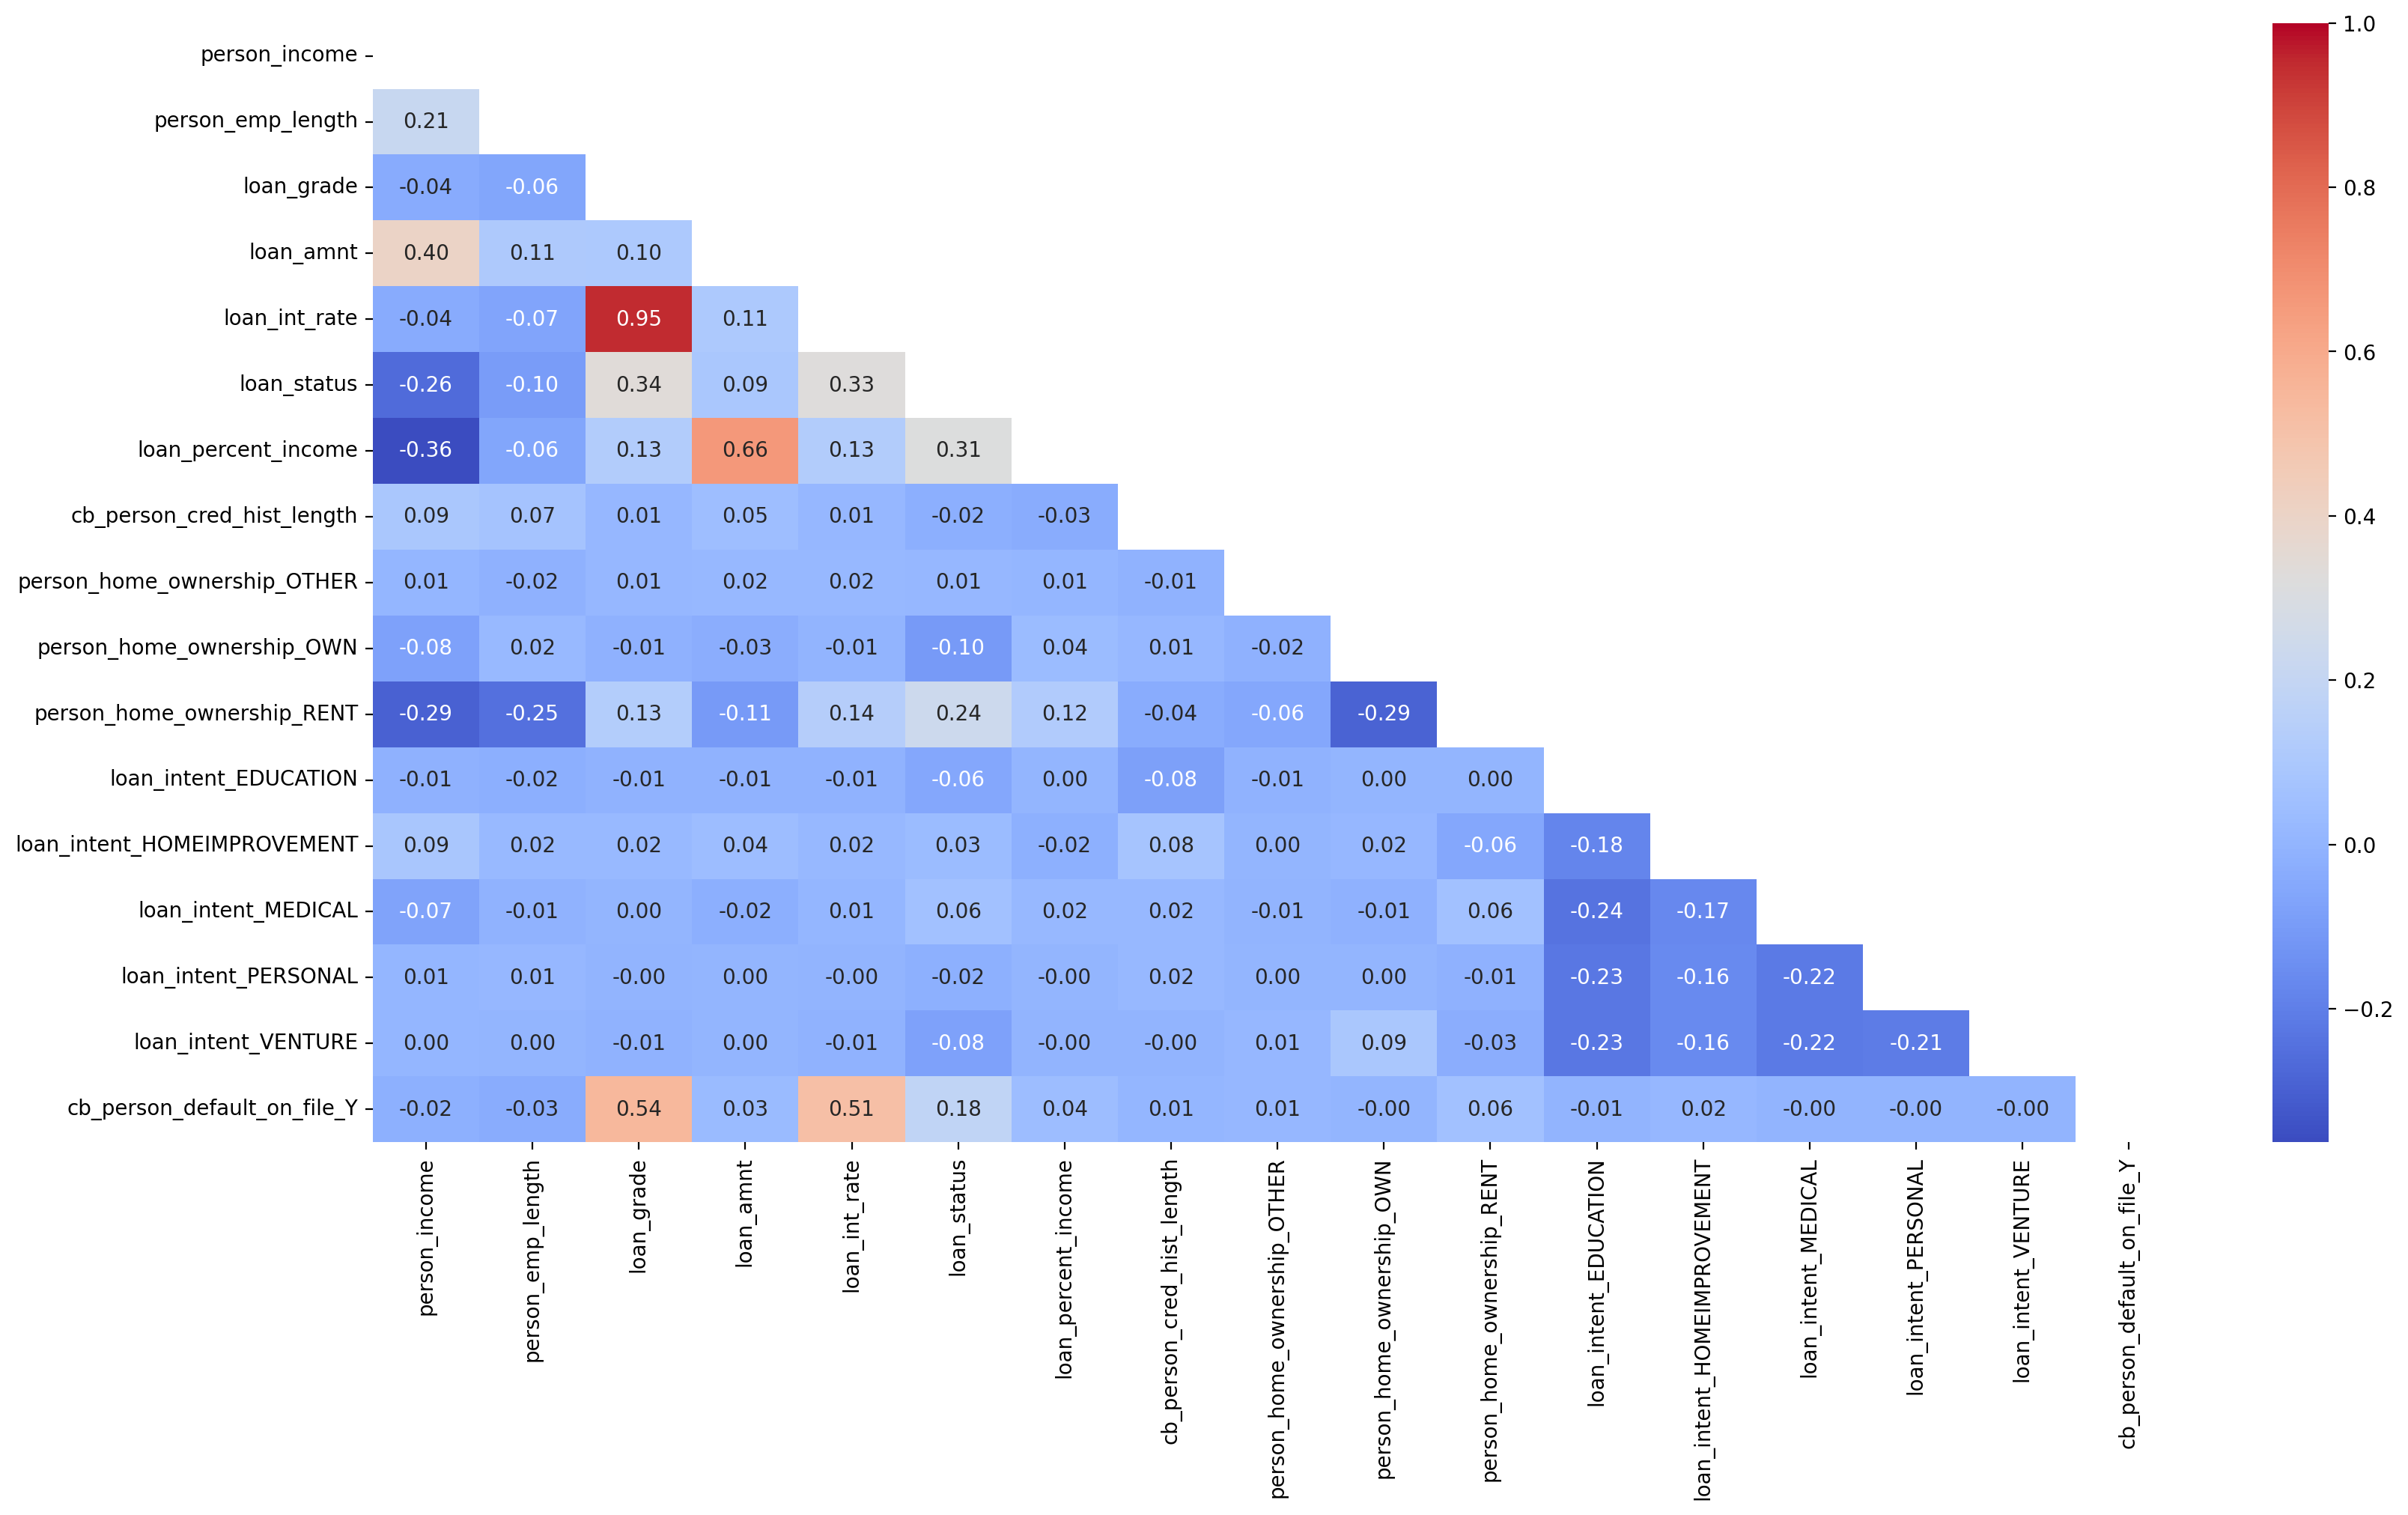

In [51]:
corr = df_credit.corr(method='spearman')
mask = np.triu(corr)
f, ax = plt.subplots(figsize=(16, 10))
ax = sns.heatmap(corr, mask=mask, vmin=corr.values.ravel().min(), 
                 vmax=corr.values.ravel().max(), 
                 annot=True, fmt='.2f', cmap='coolwarm')

In [52]:
vif = pd.DataFrame()
c_df_credit = sm.add_constant(df_credit)
vif["features"] = c_df_credit.columns
vif["VIF Factor"] = [variance_inflation_factor(c_df_credit.values, i) for i in range(c_df_credit.shape[1])]
print(vif)

                       features  VIF Factor
0                         const   63.465168
1                 person_income    1.959179
2             person_emp_length    1.106623
3                    loan_grade    8.558868
4                     loan_amnt    2.831445
5                 loan_int_rate    7.872060
6                   loan_status    1.478654
7           loan_percent_income    3.002920
8    cb_person_cred_hist_length    1.043414
9   person_home_ownership_OTHER    1.007174
10    person_home_ownership_OWN    1.153872
11   person_home_ownership_RENT    1.302082
12        loan_intent_EDUCATION    1.827439
13  loan_intent_HOMEIMPROVEMENT    1.528379
14          loan_intent_MEDICAL    1.770087
15         loan_intent_PERSONAL    1.731616
16          loan_intent_VENTURE    1.772410
17  cb_person_default_on_file_Y    1.406403


In [53]:
df_credit.drop('loan_int_rate', axis=1, inplace=True)

In [54]:
FACTORS_NUM.remove('loan_int_rate')

In [55]:
vif["features"] = c_df_credit.columns
vif["VIF Factor"] = [variance_inflation_factor(c_df_credit.values, i) for i in range(c_df_credit.shape[1])]
print(vif)

                       features  VIF Factor
0                         const   63.465168
1                 person_income    1.959179
2             person_emp_length    1.106623
3                    loan_grade    8.558868
4                     loan_amnt    2.831445
5                 loan_int_rate    7.872060
6                   loan_status    1.478654
7           loan_percent_income    3.002920
8    cb_person_cred_hist_length    1.043414
9   person_home_ownership_OTHER    1.007174
10    person_home_ownership_OWN    1.153872
11   person_home_ownership_RENT    1.302082
12        loan_intent_EDUCATION    1.827439
13  loan_intent_HOMEIMPROVEMENT    1.528379
14          loan_intent_MEDICAL    1.770087
15         loan_intent_PERSONAL    1.731616
16          loan_intent_VENTURE    1.772410
17  cb_person_default_on_file_Y    1.406403


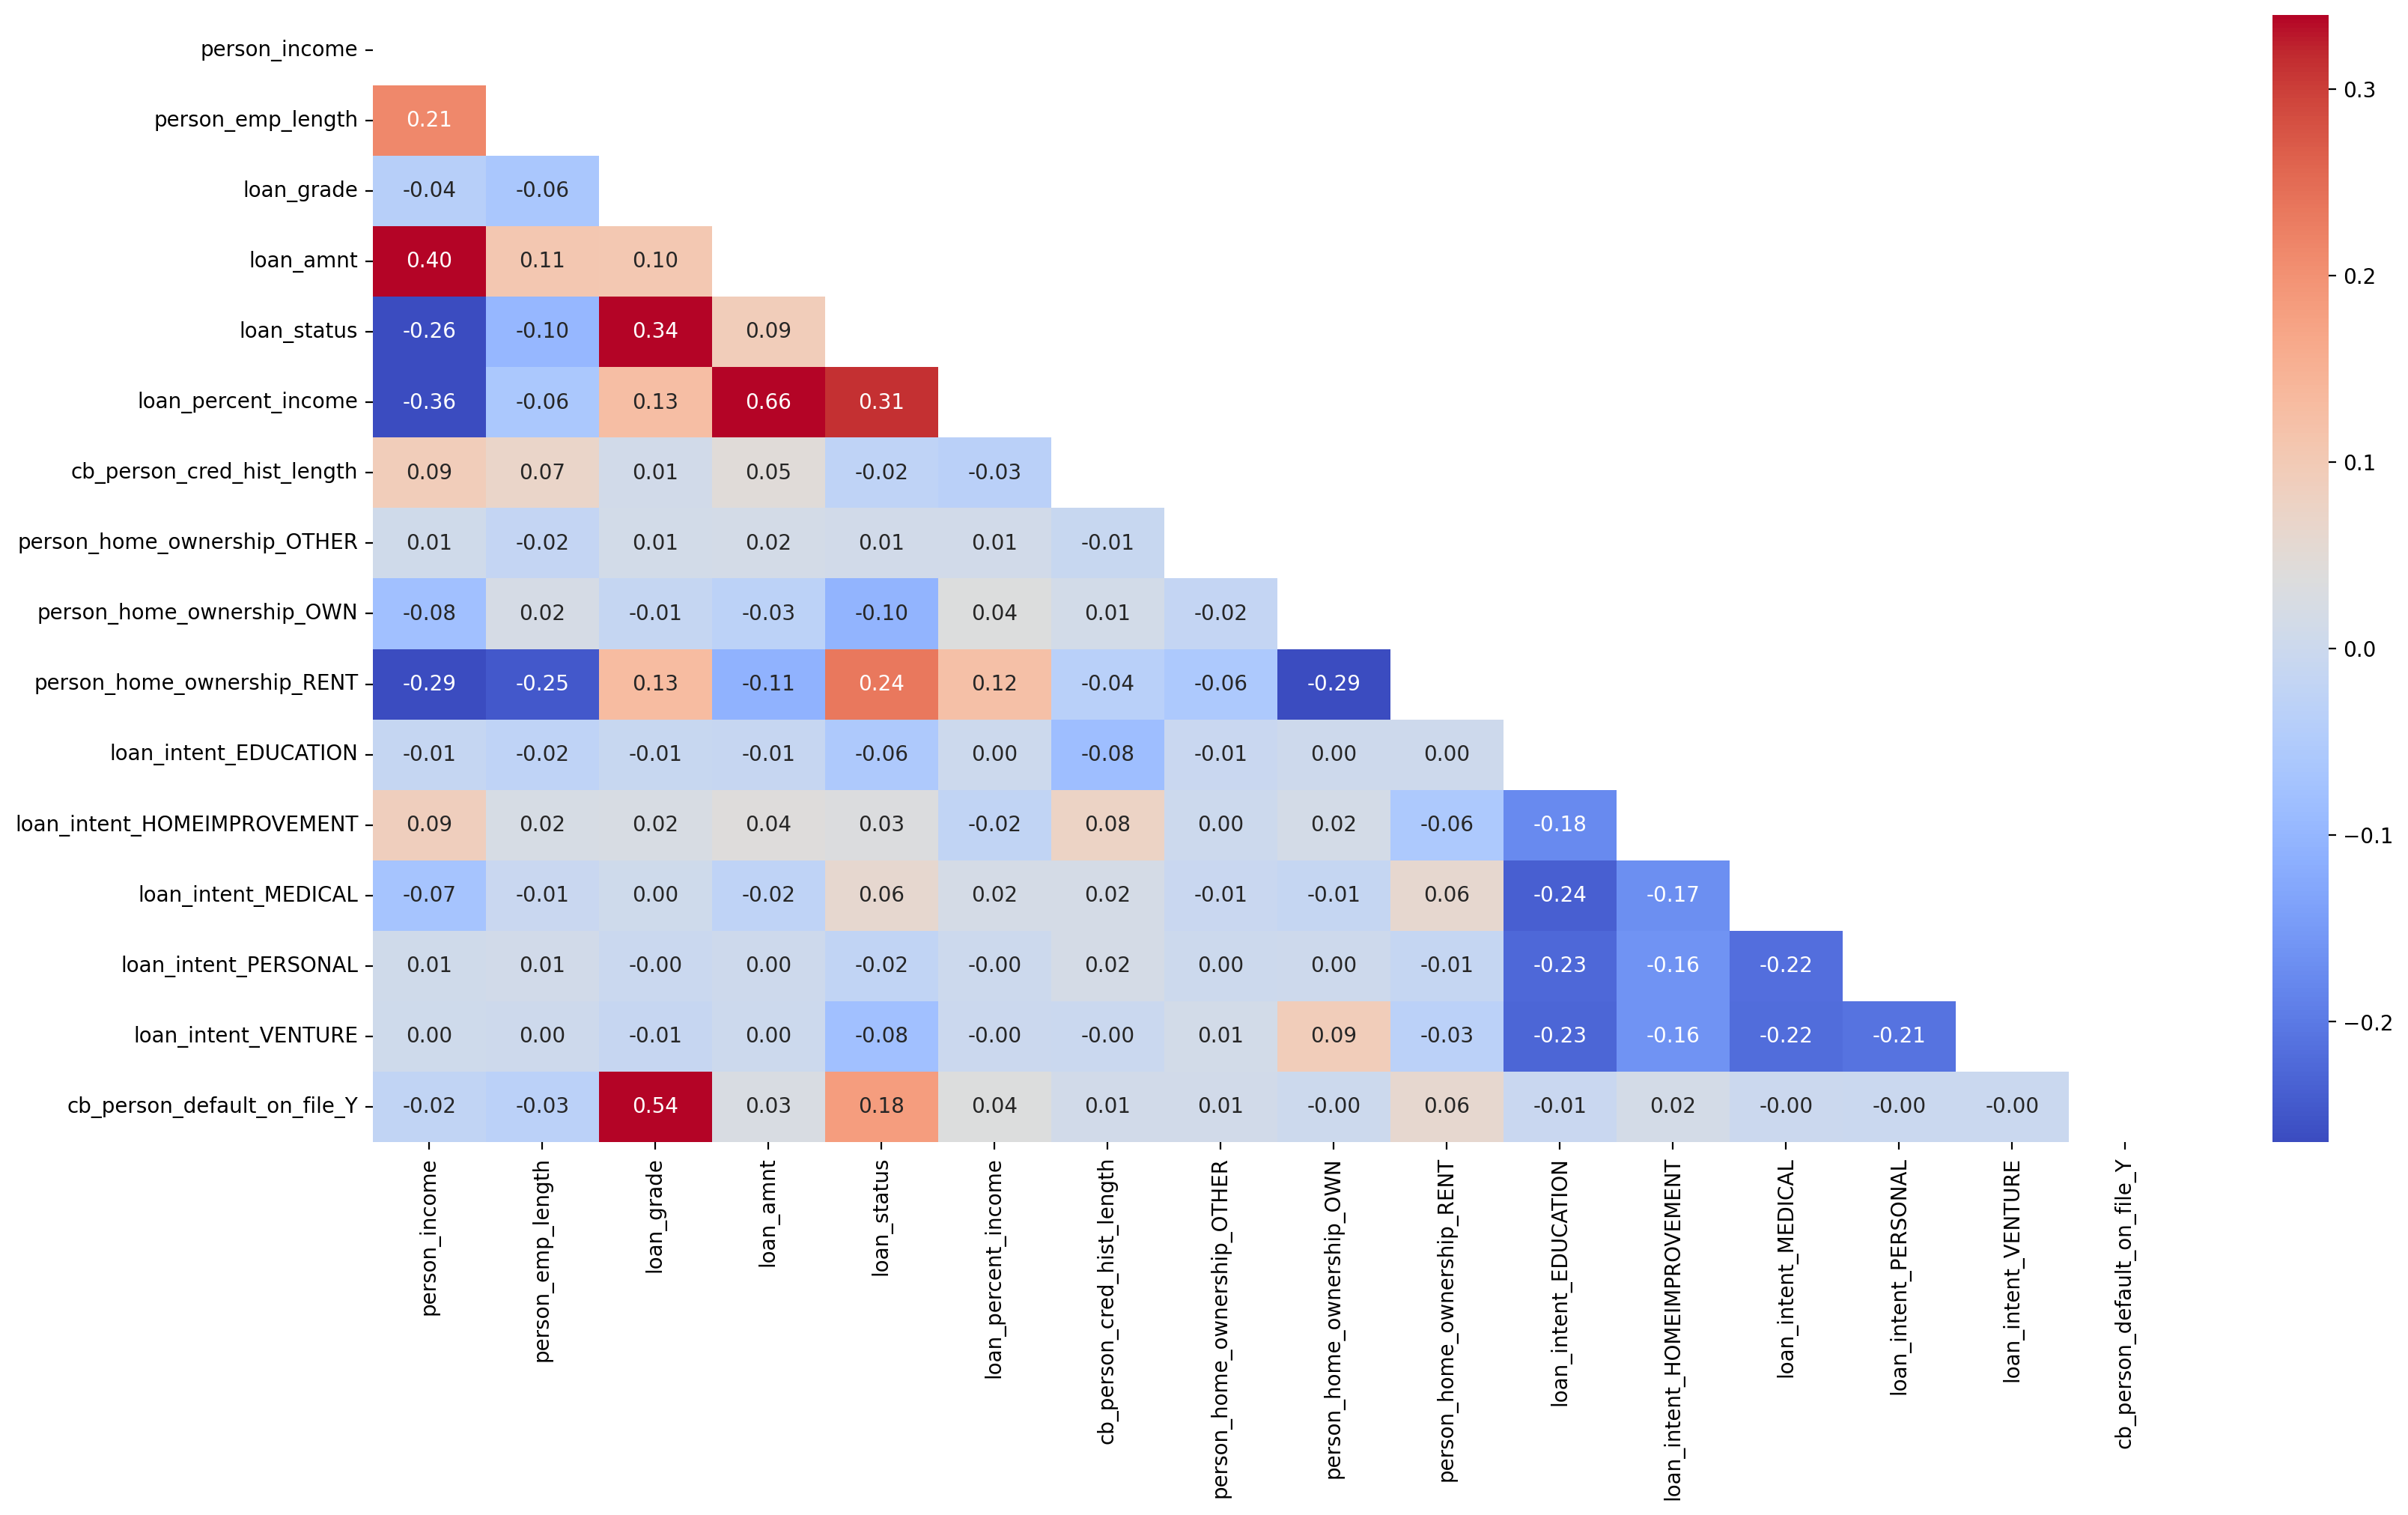

In [56]:
corr = df_credit.corr(method='spearman')
mask = np.triu(corr)
f, ax = plt.subplots(figsize=(16, 10))
ax = sns.heatmap(corr, mask=mask, vmin=corr.loan_status.min(), 
                 vmax=corr.drop(['loan_status'], axis=0).loan_status.max(), 
                 annot=True, fmt='.2f', cmap='coolwarm')

In [57]:
df_credit.drop('loan_amnt', axis=1, inplace=True)

In [58]:
FACTORS_NUM.remove('loan_amnt')

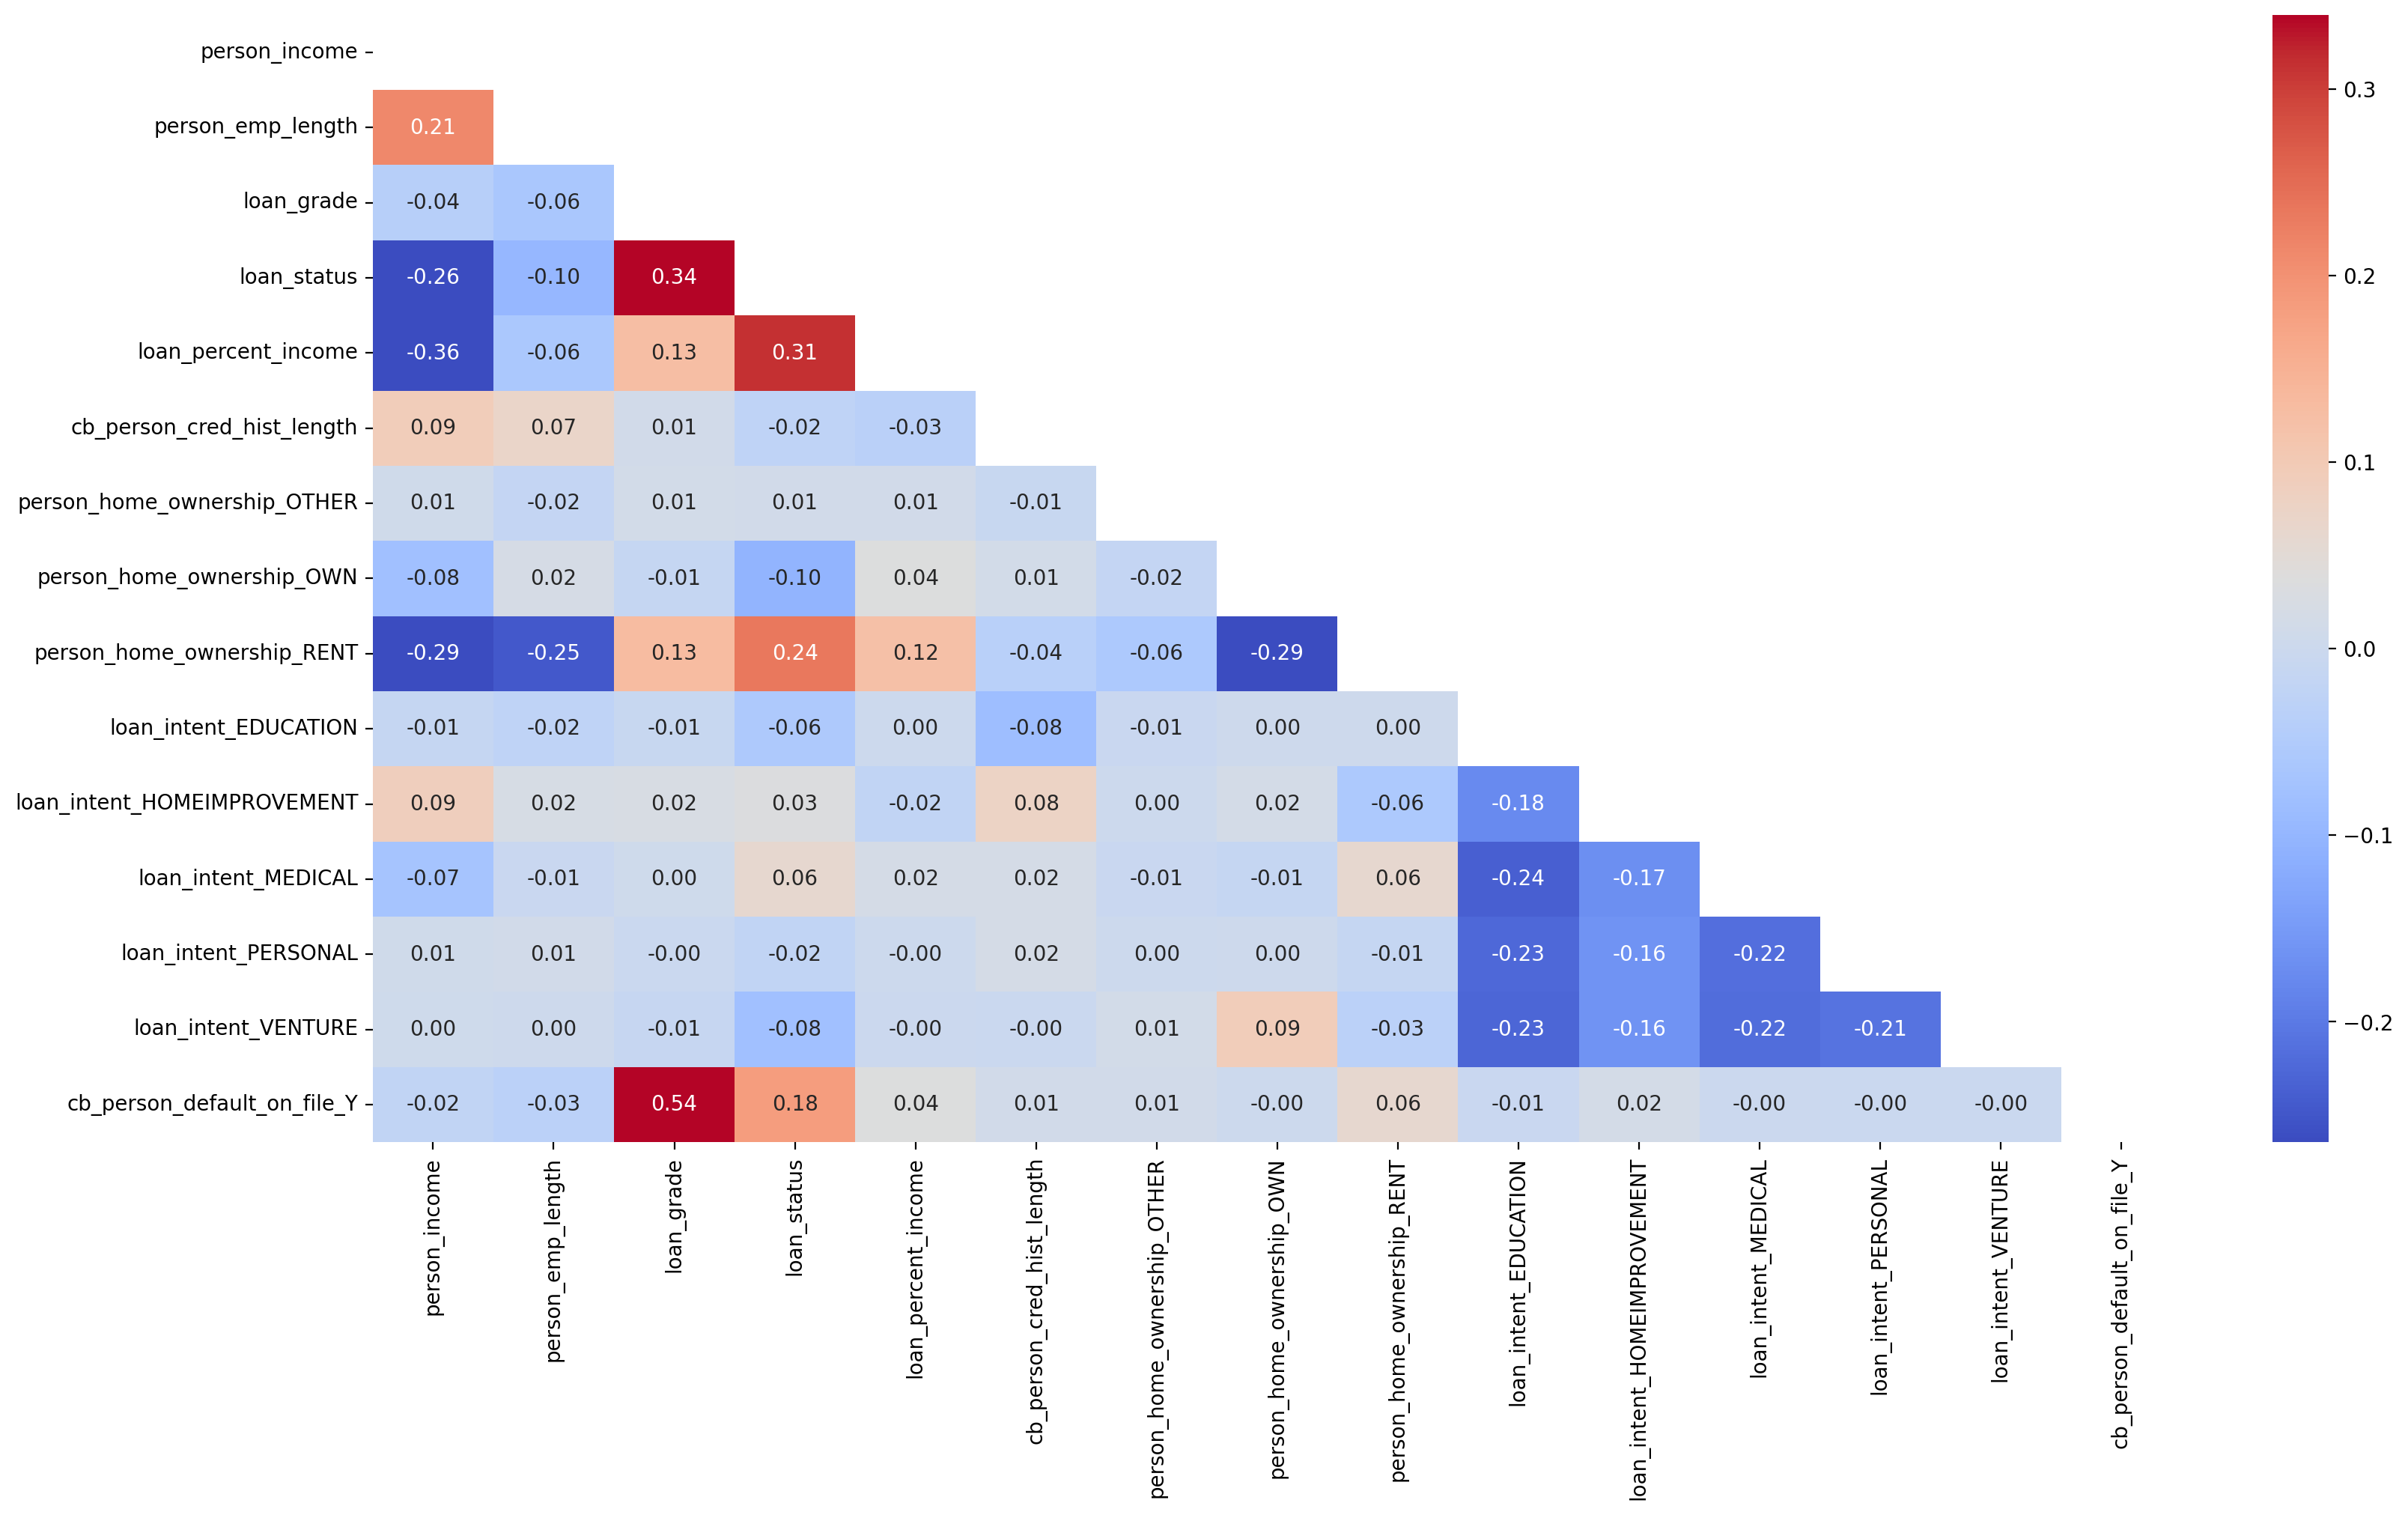

In [59]:
corr = df_credit.corr(method='spearman')
mask = np.triu(corr)
f, ax = plt.subplots(figsize=(16, 10))
ax = sns.heatmap(corr, mask=mask, vmin=corr.loan_status.min(), 
                 vmax=corr.drop(['loan_status'], axis=0).loan_status.max(), 
                 annot=True, fmt='.2f', cmap='coolwarm')

In [60]:
vif = pd.DataFrame()
c_df_credit = sm.add_constant(df_credit)
vif["features"] = c_df_credit.columns
vif["VIF Factor"] = [variance_inflation_factor(c_df_credit.values, i) for i in range(c_df_credit.shape[1])]
print(vif)

                       features  VIF Factor
0                         const   17.807909
1                 person_income    1.194604
2             person_emp_length    1.100487
3                    loan_grade    1.600081
4                   loan_status    1.431617
5           loan_percent_income    1.265511
6    cb_person_cred_hist_length    1.043141
7   person_home_ownership_OTHER    1.006691
8     person_home_ownership_OWN    1.136782
9    person_home_ownership_RENT    1.270640
10        loan_intent_EDUCATION    1.827332
11  loan_intent_HOMEIMPROVEMENT    1.526802
12          loan_intent_MEDICAL    1.770085
13         loan_intent_PERSONAL    1.731608
14          loan_intent_VENTURE    1.772249
15  cb_person_default_on_file_Y    1.404949


## Разделение на обучающую и тестовую выборки

На графике видно, что выборка несбалансированная. Можно решить эту проблему путем стратификации.

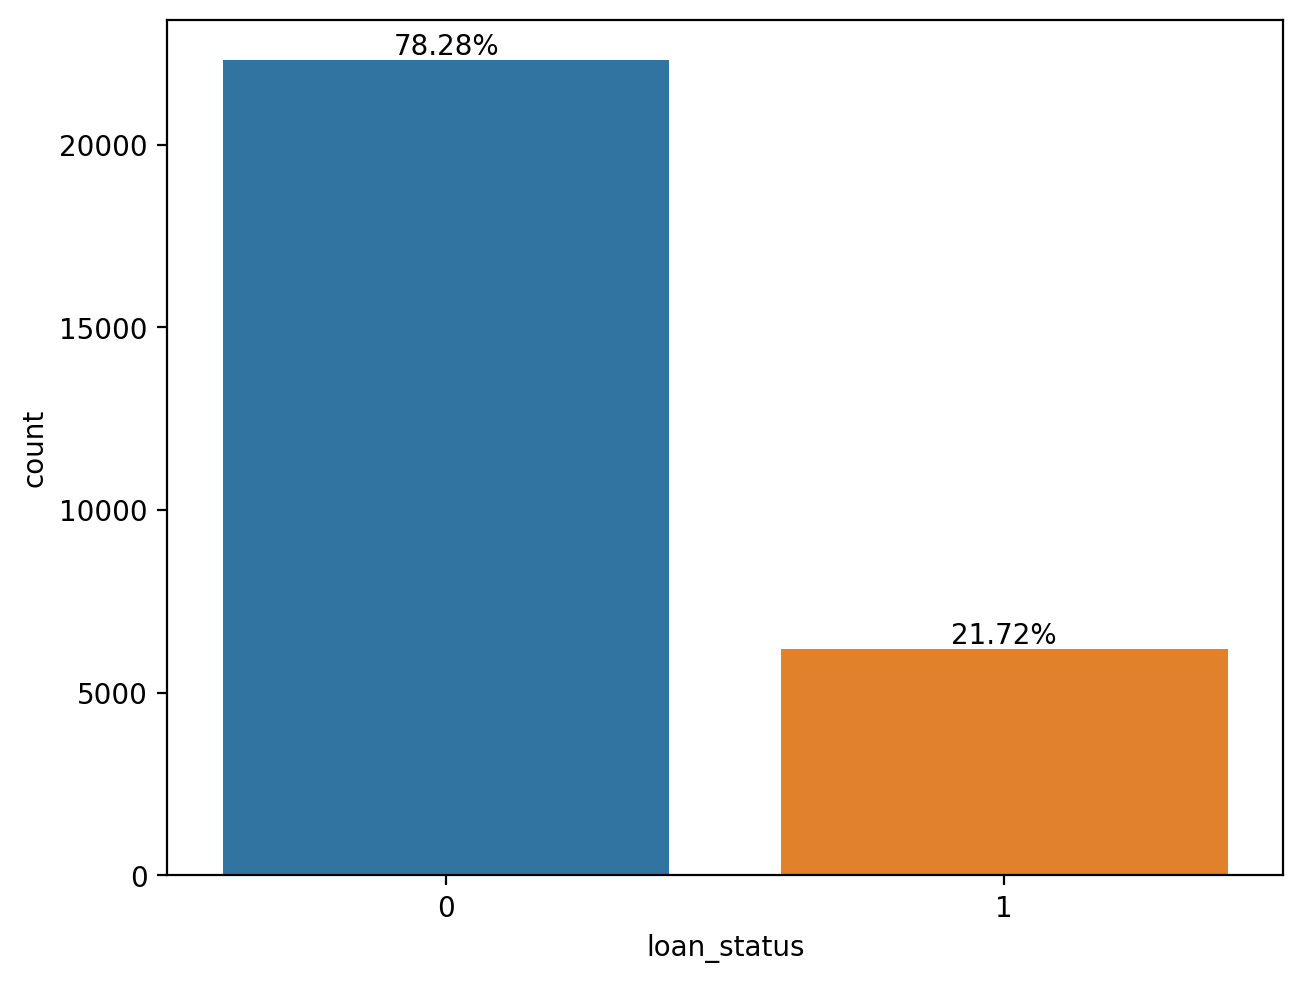

In [135]:
ax = sns.countplot(x=df_credit["loan_status"])

abs_values = list(map(lambda x: x + '%', list(map(str, round(df_credit['loan_status'].value_counts() / df_credit.shape[0] * 100, 2).values))))

ax.bar_label(container=ax.containers[0], labels=abs_values)
plt.show()

In [136]:
X_train, X_test, y_train, y_test = train_test_split(df_credit.drop(TARGET, axis=1), df_credit[TARGET], train_size=0.67, random_state=42, stratify=df_credit[TARGET])

In [137]:
print(y_train.value_counts())
print(y_test.value_counts())

0    14943
1     4145
Name: loan_status, dtype: int64
0    7360
1    2042
Name: loan_status, dtype: int64


## Масштабирование количественных переменных

In [138]:
X_train['person_income'] = np.log(X_train['person_income'])
X_test['person_income'] = np.log(X_test['person_income'])

In [139]:
scaler = StandardScaler()

In [140]:
X_train[FACTORS_NUM+FACTORS_CAT_ORDINAL] = scaler.fit_transform(X_train[FACTORS_NUM+FACTORS_CAT_ORDINAL])

In [141]:
X_test[FACTORS_NUM+FACTORS_CAT_ORDINAL] = scaler.transform(X_test[FACTORS_NUM+FACTORS_CAT_ORDINAL])

In [142]:
X_train

person_income  person_emp_length  loan_grade  loan_percent_income  \
17482       0.116683          -0.941800   -1.050867            -1.025960   
10486       0.588076           0.055638   -0.199758            -1.025960   
20309       0.116683          -0.692441   -0.199758            -0.838001   
13429       1.500345           0.554357   -1.050867            -0.650042   
8628        0.260497          -0.692441   -1.050867            -0.180145   
...              ...                ...         ...                  ...   
4928       -0.366851          -0.692441   -0.199758             0.665670   
8882       -0.072619           0.554357    0.651352             0.101793   
3299       -0.685166          -0.193721   -1.050867             0.853628   
26230      -0.611821           0.803717   -0.199758            -0.368104   
12788       1.192620          -0.193721   -1.050867            -0.744022   

       cb_person_cred_hist_length  person_home_ownership_OTHER  \
17482                    0.810605                            0   
10486                   -0.947015                            0   
20309                    0.308428                            0   
13429                   -0.947015                            0   
8628                    -0.695926                            0   
...                           ...                          ...   
4928                    -0.695926                            0   
8882                    -0.947015                            0   
3299                    -0.947015                            0   
26230                    1.563871                            0   
12788                   -0.947015                            0   

       person_home_ownership_OWN  person_home_ownership_RENT  \
17482                          0                           1   
10486                          0                           0   
20309                          0                           0   
13429                          1                           0   
8628                           0                           0   
...                          ...                         ...   
4928                           1                           0   
8882                           0                           1   
3299                           0                           0   
26230                          0                           1   
12788                          0                           0   

       loan_intent_EDUCATION  loan_intent_HOMEIMPROVEMENT  \
17482                      0                            0   
10486                      1                            0   
20309                      0                            0   
13429                      0                            0   
8628                       0                            1   
...                      ...                          ...   
4928                       0                            0   
8882                       0                            0   
3299                       0                            0   
26230                      0                            0   
12788                      0                            0   

       loan_intent_MEDICAL  loan_intent_PERSONAL  loan_intent_VENTURE  \
17482                    0                     0                    0   
10486                    0                     0                    0   
20309                    1                     0                    0   
13429                    0                     1                    0   
8628                     0                     0                    0   
...                    ...                   ...                  ...   
4928                     0                     0                    1   
8882                     1                     0                    0   
3299                     0                     0                    0   
26230                    0                     0                    1

# Обучение моделей без балансировки

In [143]:
scores = lambda pred: [balanced_accuracy_score(y_test, pred), f1_score(y_test, pred), matthews_corrcoef(y_test, pred)]
score_names = ['balanced accuracy', 'f-score', 'matthews score']

In [144]:
def model_scores(model, name):
    model = model.fit(X_train.values, y_train.values.ravel())
    predictions = model.predict(X_test.values)
    proba_predictions = model.predict_proba(X_test.values)[:, 1]
    print(name)
    print('Confusion matrix:', '\n', confusion_matrix(y_test, predictions))
    res_scores = scores(predictions)
    for (i, j) in zip(score_names, res_scores):
        print(i, " = ", j)
    res_scores.append(roc_auc_score(y_test, proba_predictions))
    print('ROC AUC = ', res_scores[-1])
    print(classification_report(y_test, predictions))
    return model, res_scores, proba_predictions

In [145]:
logit_credit = LogisticRegression()

In [146]:
logit_regression_model = model_scores(logit_credit, 'Logistic Regression')

Logistic Regression
Confusion matrix: 
 [[6996  364]
 [1000 1042]]
balanced accuracy  =  0.7304137567602096
f-score  =  0.6044083526682134
matthews score  =  0.5328146083838511
ROC AUC =  0.8681598789549888
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      7360
           1       0.74      0.51      0.60      2042

    accuracy                           0.85      9402
   macro avg       0.81      0.73      0.76      9402
weighted avg       0.85      0.85      0.84      9402



In [147]:
neighbours_credit = KNeighborsClassifier(n_neighbors=10)

In [148]:
KNN_model = model_scores(neighbours_credit, 'K-neighbours')

K-neighbours
Confusion matrix: 
 [[7258  102]
 [ 821 1221]]
balanced accuracy  =  0.7920422486479581
f-score  =  0.725705794947994
matthews score  =  0.6926019808185427
ROC AUC =  0.892631737586765
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      7360
           1       0.92      0.60      0.73      2042

    accuracy                           0.90      9402
   macro avg       0.91      0.79      0.83      9402
weighted avg       0.90      0.90      0.89      9402



In [149]:
random_forest_credit = RandomForestClassifier()

In [150]:
random_forest_model = model_scores(random_forest_credit, 'Random Forest')

Random Forest
Confusion matrix: 
 [[7302   58]
 [ 570 1472]]
balanced accuracy  =  0.8564907326576672
f-score  =  0.8241881298992161
matthews score  =  0.7964467749017882
ROC AUC =  0.9262516368223822
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7360
           1       0.96      0.72      0.82      2042

    accuracy                           0.93      9402
   macro avg       0.94      0.86      0.89      9402
weighted avg       0.94      0.93      0.93      9402



In [151]:
gb_credit = GradientBoostingClassifier()

In [152]:
gradient_boosting_model = model_scores(gb_credit, 'Gradient Boosting')

Gradient Boosting
Confusion matrix: 
 [[7261   99]
 [ 570 1472]]
balanced accuracy  =  0.8537054065707107
f-score  =  0.8148353169111542
matthews score  =  0.7818829907302357
ROC AUC =  0.9320608591853682
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7360
           1       0.94      0.72      0.81      2042

    accuracy                           0.93      9402
   macro avg       0.93      0.85      0.89      9402
weighted avg       0.93      0.93      0.93      9402



In [153]:
xgb_credit = XGBClassifier()

In [154]:
xgb_model = model_scores(xgb_credit, 'XGBoost')

XGBoost
Confusion matrix: 
 [[7278   82]
 [ 526 1516]]
balanced accuracy  =  0.8656340490993484
f-score  =  0.8329670329670329
matthews score  =  0.8027797072227459
ROC AUC =  0.9492225759059746
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7360
           1       0.95      0.74      0.83      2042

    accuracy                           0.94      9402
   macro avg       0.94      0.87      0.90      9402
weighted avg       0.94      0.94      0.93      9402



In [155]:
models_and_scores_and_predictions = [logit_regression_model, KNN_model, random_forest_model, 
                    gradient_boosting_model, xgb_model]
model_names = ['LogisticRegression', 'KNeighboursClassifier', 'RandomForestClassifier', 
              'GradientBoostingClassifier', 'XGBoostClassifier']
fitted_models = [model[0] for model in models_and_scores_and_predictions]
fitted_models_scores = [scores[1] for scores in models_and_scores_and_predictions]
fitted_models_predictions = [pred[2] for pred in models_and_scores_and_predictions]
score_names.append('AUC ROC')

c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names


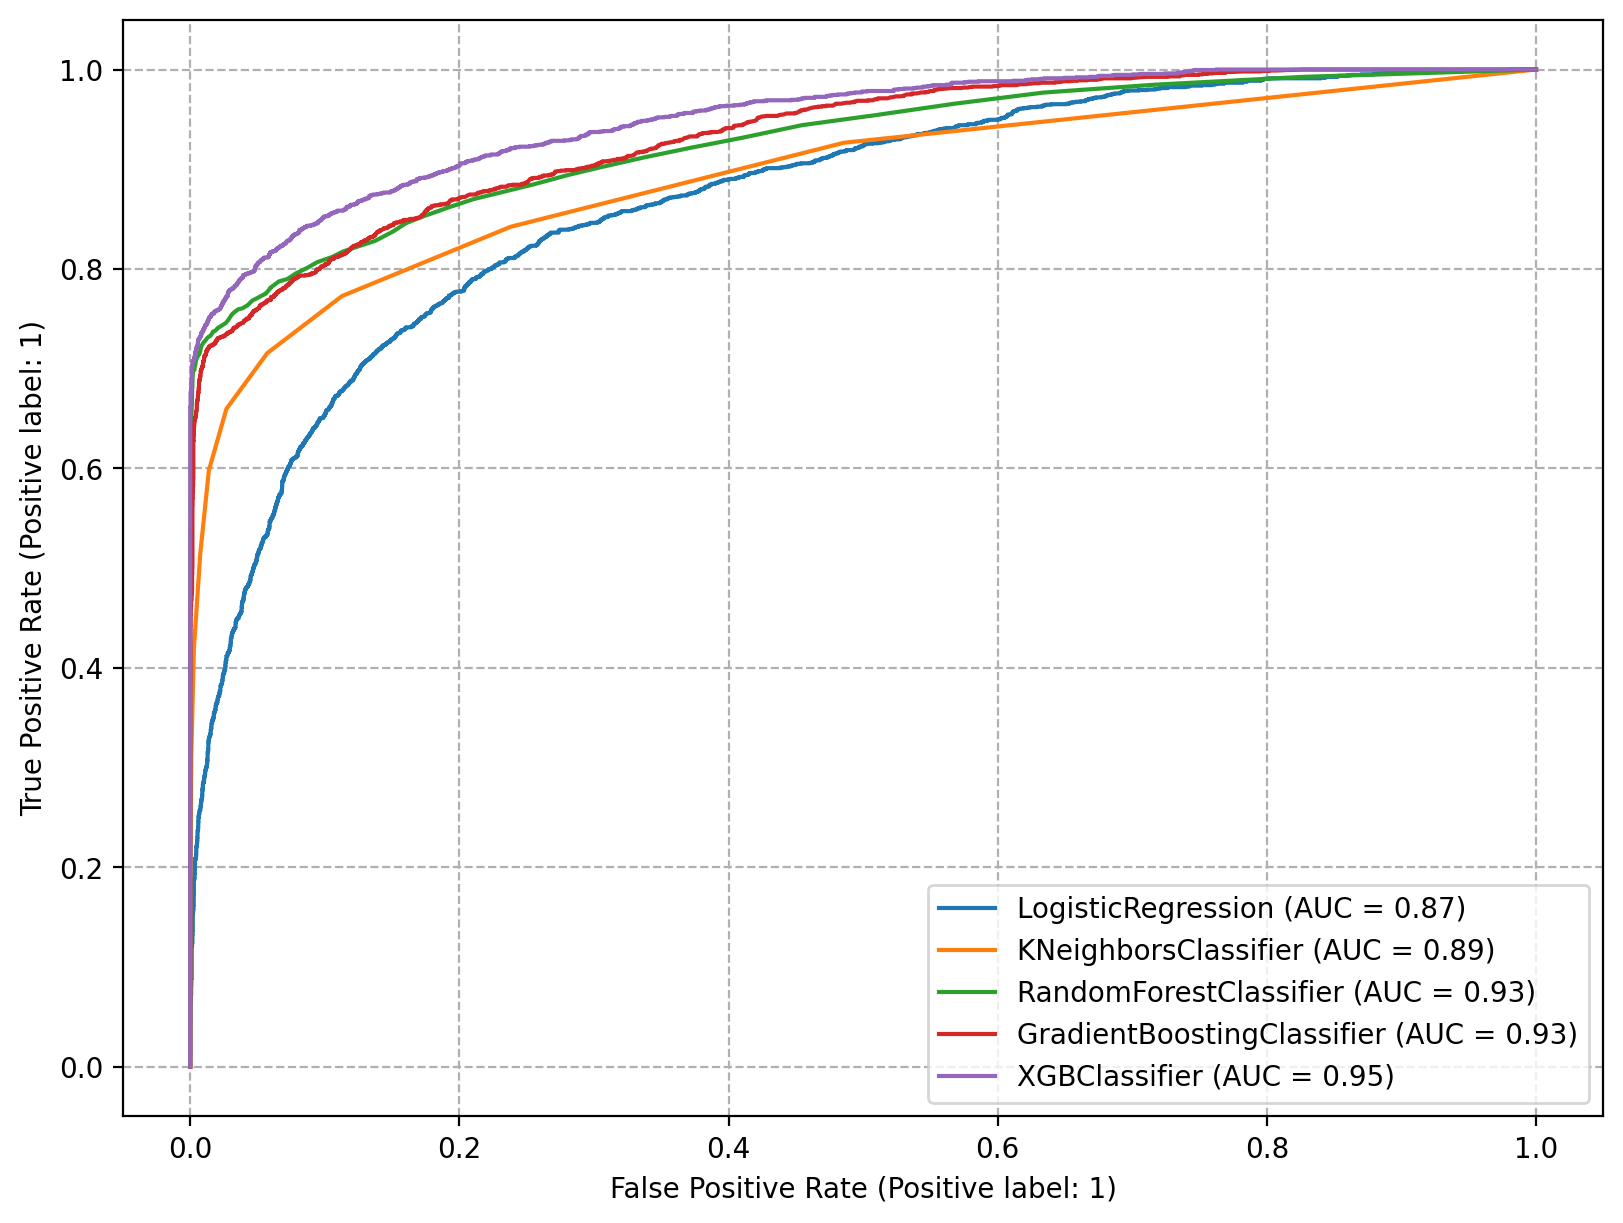

In [156]:
fig, ax_roc = plt.subplots(1, 1, figsize=(8, 6))

for clf in fitted_models:
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc)

ax_roc.grid(linestyle="--")

plt.legend()
plt.show()

c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names


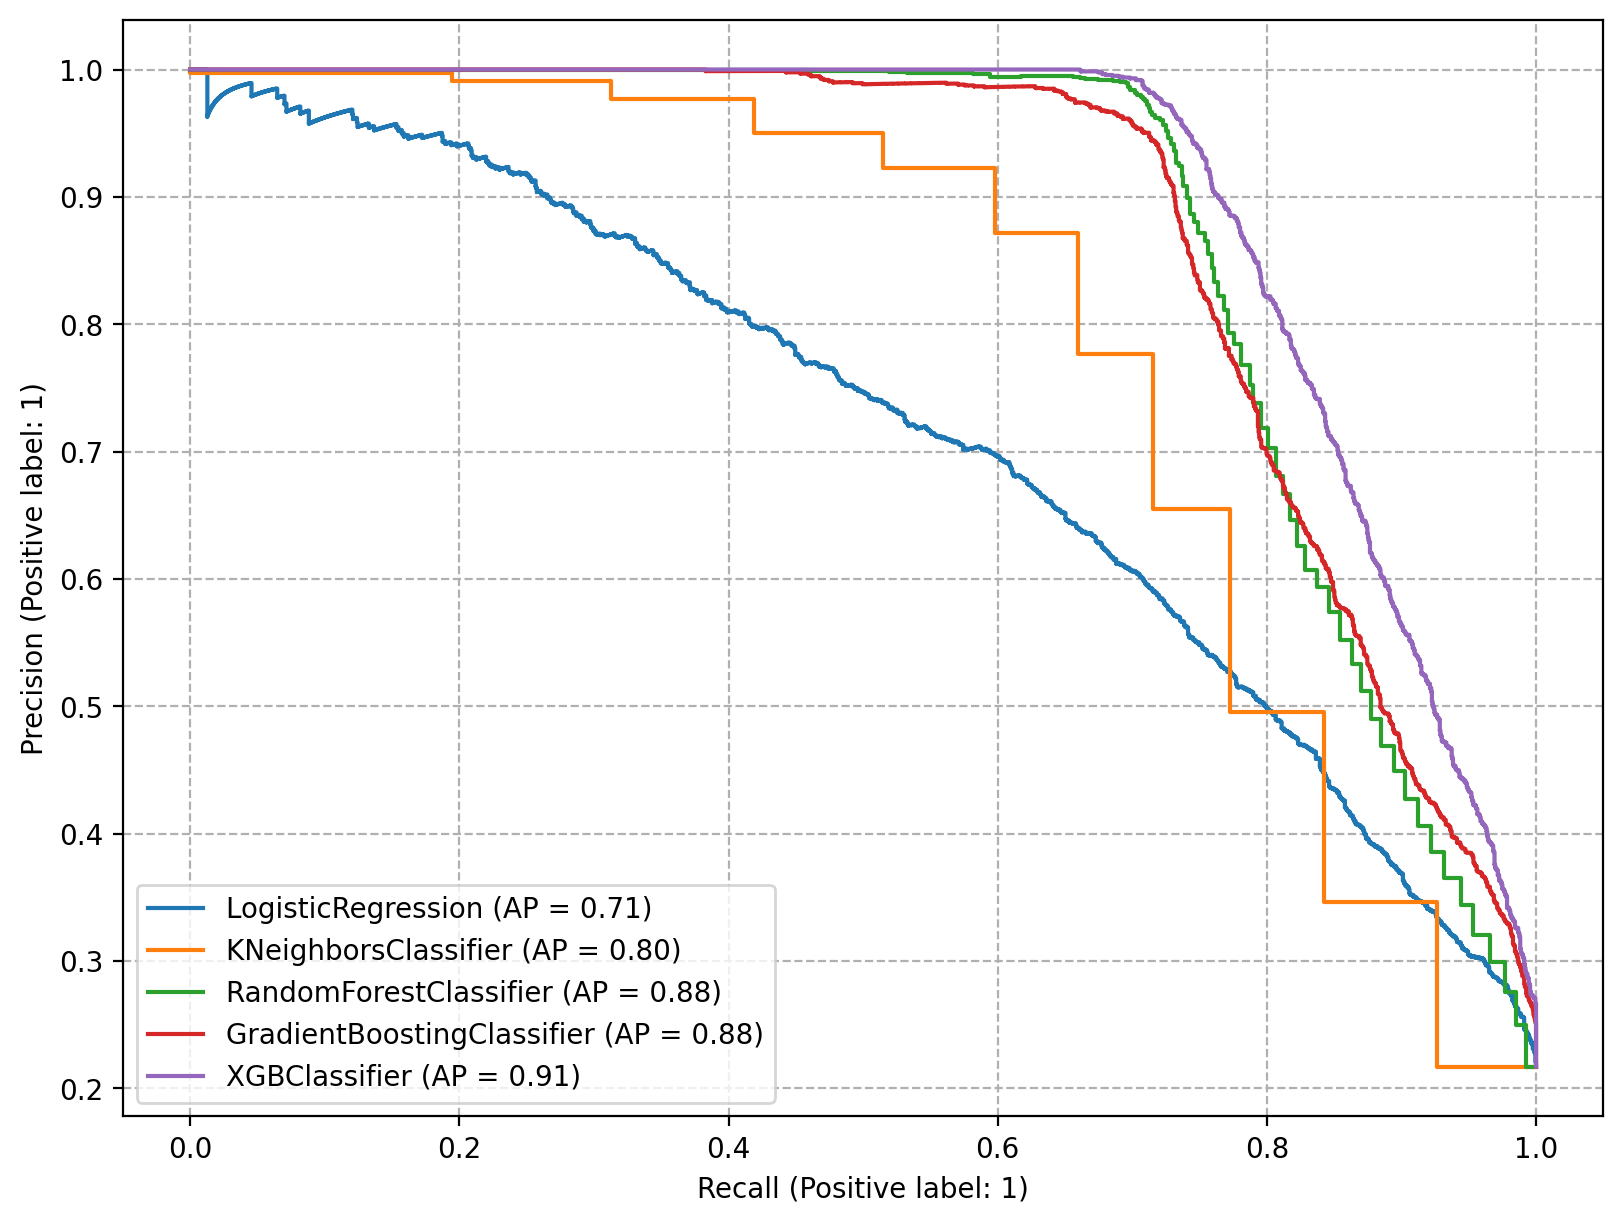

In [157]:
fig, ax_roc = plt.subplots(1, 1, figsize=(8, 6))

for clf in fitted_models:
    PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc)

ax_roc.grid(linestyle="--")

plt.legend()
plt.show()

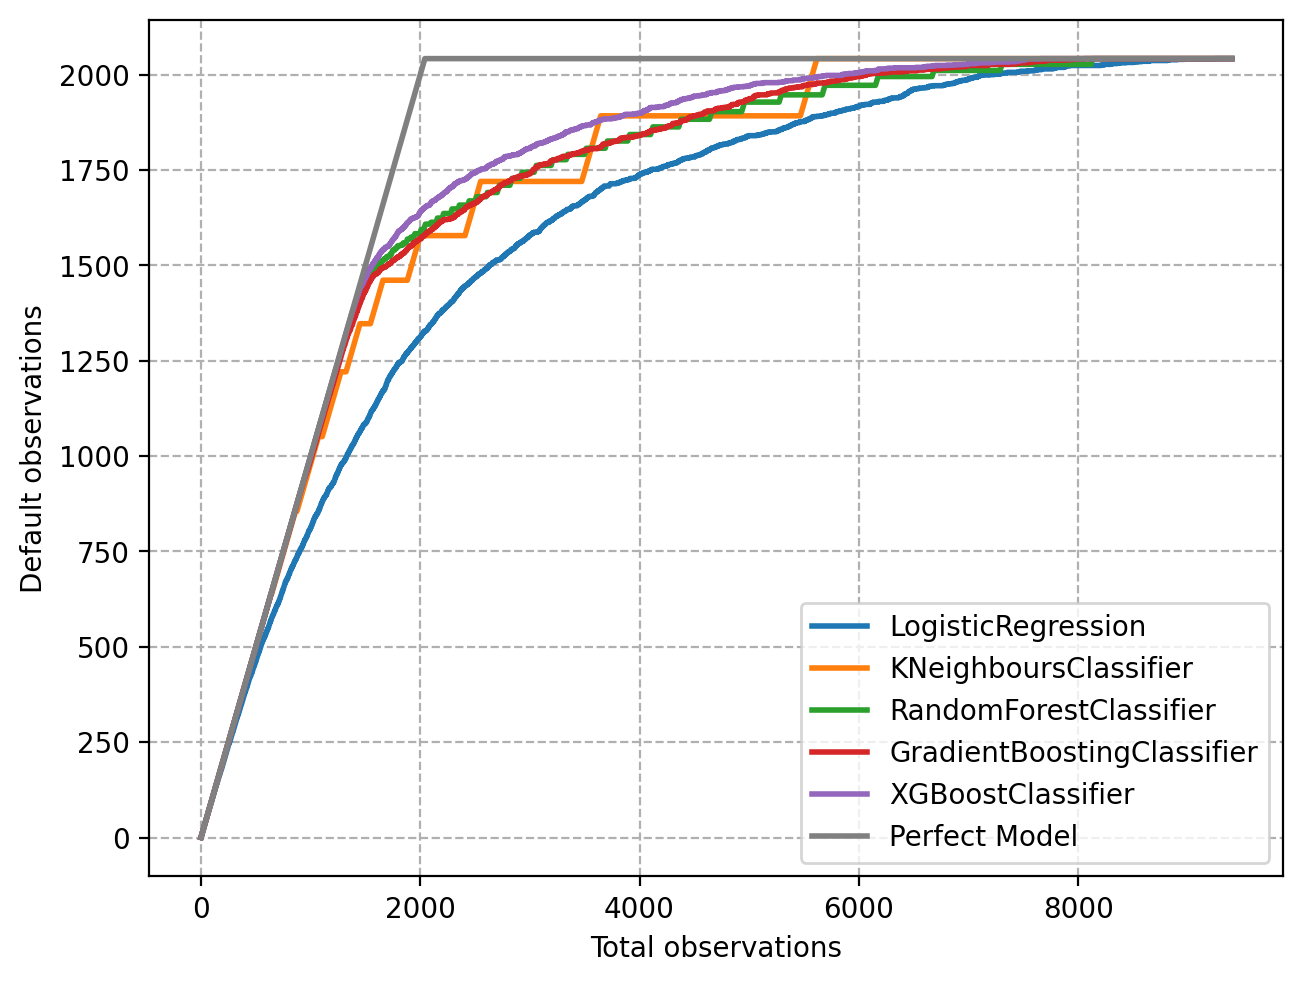

In [158]:
plt.figure()

x = np.arange(0, total + 1)
for name, pred in zip(model_names, fitted_models_predictions):
    lm = [y for _, y in sorted(zip(pred, y_test), reverse = True)]
    y = np.append([0], np.cumsum(lm))
    plt.plot(x, y, label = name, linewidth = 2)

plt.xlabel('Total observations')
plt.ylabel('Default observations')
plt.grid(linestyle="--")
plt.plot([0, one_count, total], 
         [0, one_count, one_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')
plt.legend()
plt.show()

In [159]:
df_scores = pd.DataFrame(data=fitted_models_scores,index=model_names,columns=score_names)

In [160]:
df_scores.style.background_gradient(axis=0, cmap='YlOrRd')

## Обучение моделей с балансировкой

In [106]:
X_train, X_test, y_train, y_test = train_test_split(df_credit.drop(TARGET, axis=1), df_credit[TARGET], train_size=0.67, random_state=42, stratify=df_credit[TARGET])

In [107]:
oversampled = SMOTE(random_state=42)
X_train_smote, y_train_smote = oversampled.fit_resample(X_train, y_train)

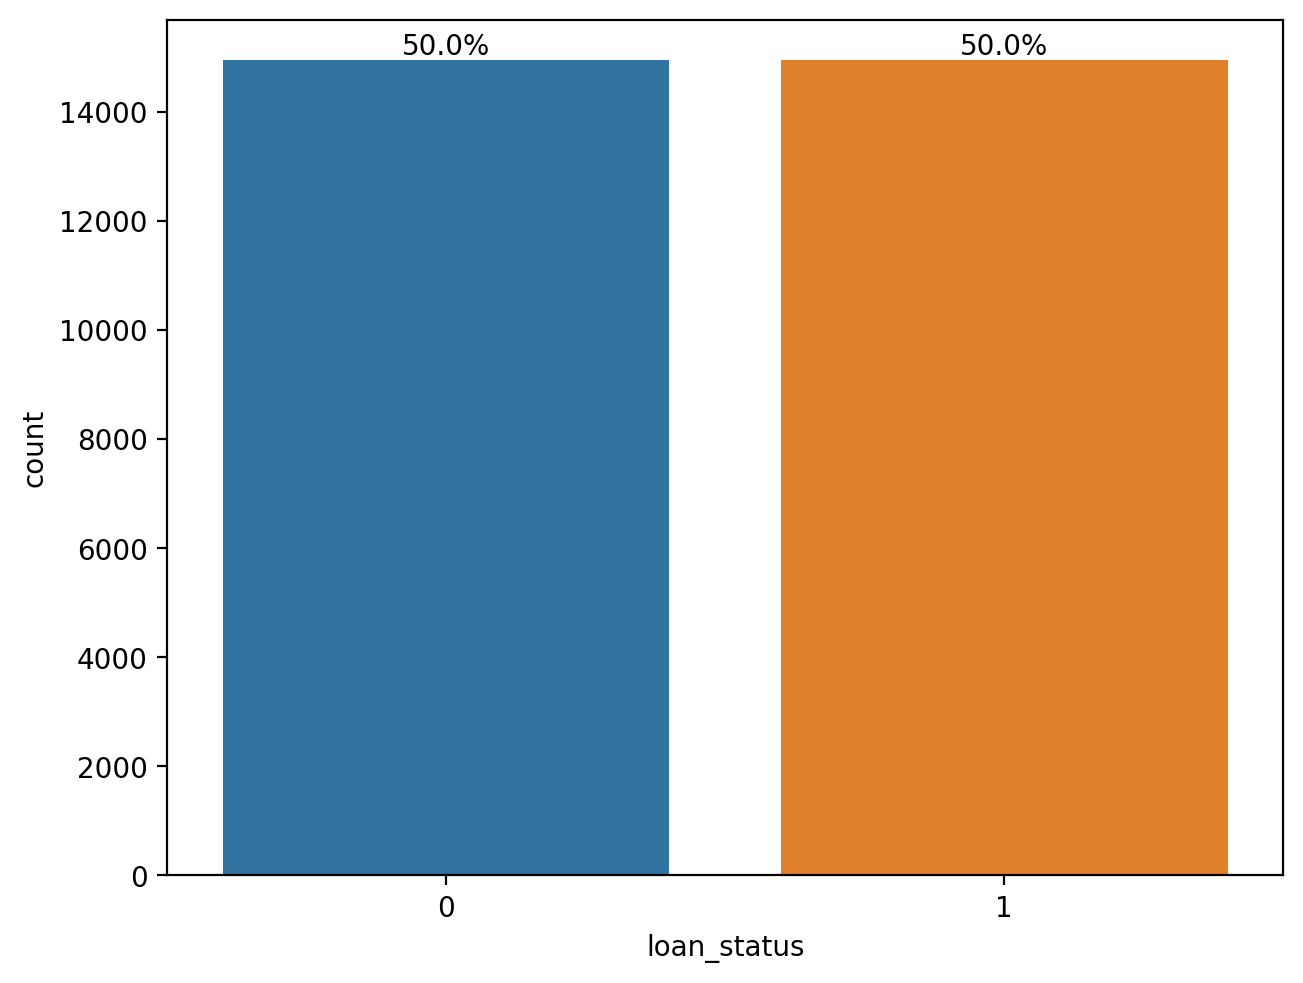

In [108]:
ax = sns.countplot(x=y_train_smote)

abs_values = list(map(lambda x: x + '%', list(map(str, round(y_train_smote.value_counts() / len(y_train_smote) * 100, 2).values))))

ax.bar_label(container=ax.containers[0], labels=abs_values)
plt.show()

In [109]:
X_train_smote['person_income'] = np.log(X_train_smote['person_income'])
X_test['person_income'] = np.log(X_test['person_income'])

In [110]:
scaler = StandardScaler()

In [111]:
X_train_smote[FACTORS_NUM+FACTORS_CAT_ORDINAL] = scaler.fit_transform(X_train_smote[FACTORS_NUM+FACTORS_CAT_ORDINAL])

In [112]:
X_test[FACTORS_NUM+FACTORS_CAT_ORDINAL] = scaler.transform(X_test[FACTORS_NUM+FACTORS_CAT_ORDINAL])

In [113]:
scores = lambda pred: [balanced_accuracy_score(y_test, pred), f1_score(y_test, pred), matthews_corrcoef(y_test, pred)]
score_names = ['balanced accuracy', 'f-score', 'matthews score']

In [114]:
def model_scores_smote(model, name):
    model = model.fit(X_train_smote.values, y_train_smote.values.ravel())
    predictions = model.predict(X_test.values)
    proba_predictions = model.predict_proba(X_test.values)[:, 1]
    print(name)
    print('Confusion matrix:', '\n', confusion_matrix(y_test, predictions))
    res_scores = scores(predictions)
    for (i, j) in zip(score_names, res_scores):
        print(i, " = ", j)
    res_scores.append(roc_auc_score(y_test, proba_predictions))
    print('ROC AUC = ', res_scores[-1])
    print(classification_report(y_test, predictions))
    return model, res_scores, proba_predictions

In [115]:
logit_credit_smote = LogisticRegression()
neighbours_credit_smote = KNeighborsClassifier(n_neighbors=10)
random_forest_credit_smote = RandomForestClassifier()
gb_credit_smote = GradientBoostingClassifier()
xgb_credit_smote = XGBClassifier()

In [116]:
y_test.value_counts()

0    7360
1    2042
Name: loan_status, dtype: int64

In [117]:
logit_regression_model_smote = model_scores_smote(logit_credit_smote, 'Logistic Regression')

Logistic Regression
Confusion matrix: 
 [[6130 1230]
 [ 669 1373]]
balanced accuracy  =  0.7526302271856236
f-score  =  0.5911733046286329
matthews score  =  0.4656101935378377
ROC AUC =  0.8387858370949197
              precision    recall  f1-score   support

           0       0.90      0.83      0.87      7360
           1       0.53      0.67      0.59      2042

    accuracy                           0.80      9402
   macro avg       0.71      0.75      0.73      9402
weighted avg       0.82      0.80      0.81      9402



In [118]:
neighbours_model_smote = model_scores_smote(neighbours_credit_smote, 'KNN')

KNN
Confusion matrix: 
 [[6489  871]
 [ 582 1460]]
balanced accuracy  =  0.7983214586083549
f-score  =  0.6677338211753945
matthews score  =  0.5697308154759844
ROC AUC =  0.8746093916343738
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      7360
           1       0.63      0.71      0.67      2042

    accuracy                           0.85      9402
   macro avg       0.77      0.80      0.78      9402
weighted avg       0.85      0.85      0.85      9402



In [119]:
random_forest_model_smote = model_scores_smote(random_forest_credit_smote, 'RF')

RF
Confusion matrix: 
 [[6926  434]
 [ 517 1525]]
balanced accuracy  =  0.8439247274624196
f-score  =  0.7623094226443389
matthews score  =  0.698343260112307
ROC AUC =  0.9141325307137079
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      7360
           1       0.78      0.75      0.76      2042

    accuracy                           0.90      9402
   macro avg       0.85      0.84      0.85      9402
weighted avg       0.90      0.90      0.90      9402



In [120]:
gb_model_smote = model_scores_smote(gb_credit_smote, 'GB')

GB
Confusion matrix: 
 [[6686  674]
 [ 481 1561]]
balanced accuracy  =  0.8364352670016608
f-score  =  0.7299509001636661
matthews score  =  0.651764677941714
ROC AUC =  0.9112982330302772
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      7360
           1       0.70      0.76      0.73      2042

    accuracy                           0.88      9402
   macro avg       0.82      0.84      0.83      9402
weighted avg       0.88      0.88      0.88      9402



In [121]:

xgb_model_smote = model_scores_smote(xgb_credit_smote, 'XGB')

XGB
Confusion matrix: 
 [[7188  172]
 [ 511 1531]]
balanced accuracy  =  0.8631927884001193
f-score  =  0.8176234979973298
matthews score  =  0.7776953539686826
ROC AUC =  0.9409882281863475
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7360
           1       0.90      0.75      0.82      2042

    accuracy                           0.93      9402
   macro avg       0.92      0.86      0.89      9402
weighted avg       0.93      0.93      0.92      9402



In [122]:
models_and_scores_and_predictions_smote = [logit_regression_model_smote, neighbours_model_smote, random_forest_model_smote, 
                    gb_model_smote, xgb_model_smote]
model_names_smote = ['LogisticRegression_smote', 'KNeighboursClassifier_smote', 'RandomForestClassifier_smote', 
              'GradientBoostingClassifier_smote', 'XGBoostClassifier_smote']
fitted_models_smote = [model[0] for model in models_and_scores_and_predictions_smote]
fitted_models_scores_smote = [scores[1] for scores in models_and_scores_and_predictions_smote]
fitted_models_predictions_smote = [pred[2] for pred in models_and_scores_and_predictions_smote]
score_names.append('AUC ROC')

c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names


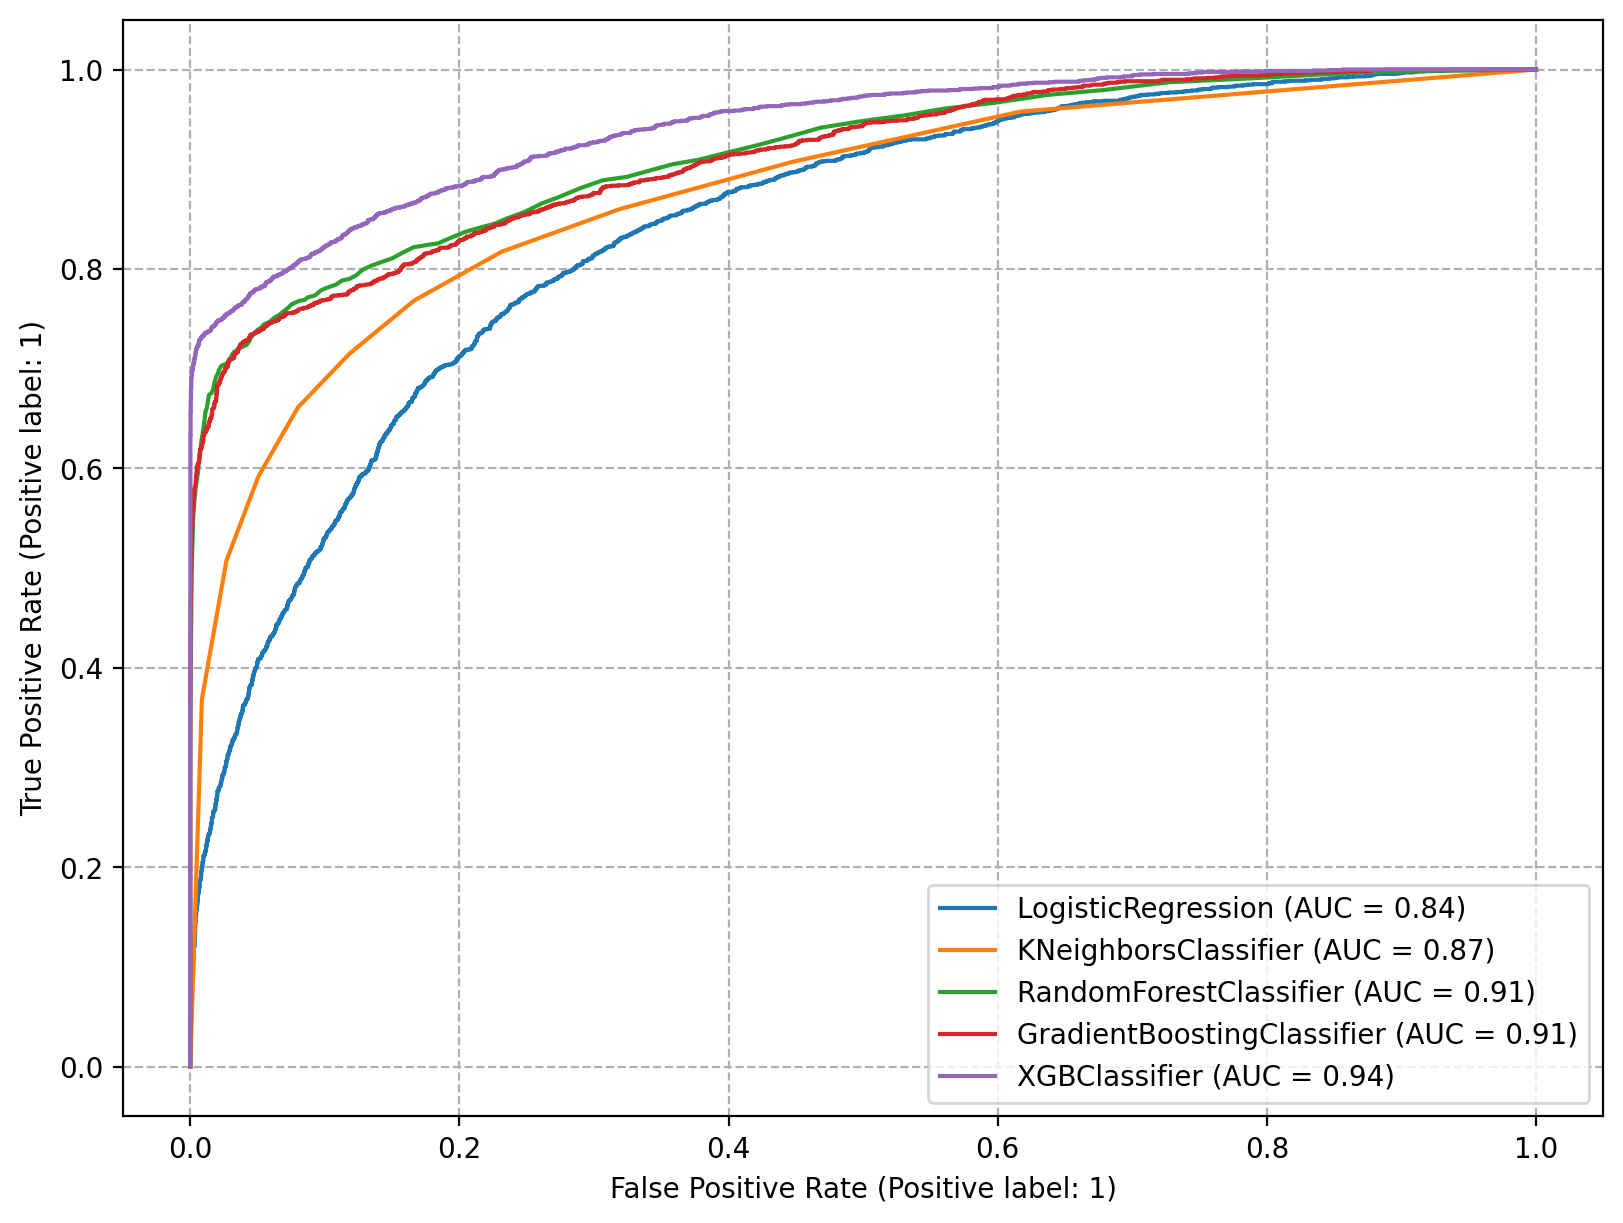

In [123]:
fig, ax_roc = plt.subplots(1, 1, figsize=(8, 6))

for clf in fitted_models_smote:
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc)

ax_roc.grid(linestyle="--")

plt.legend()
plt.show()

c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names


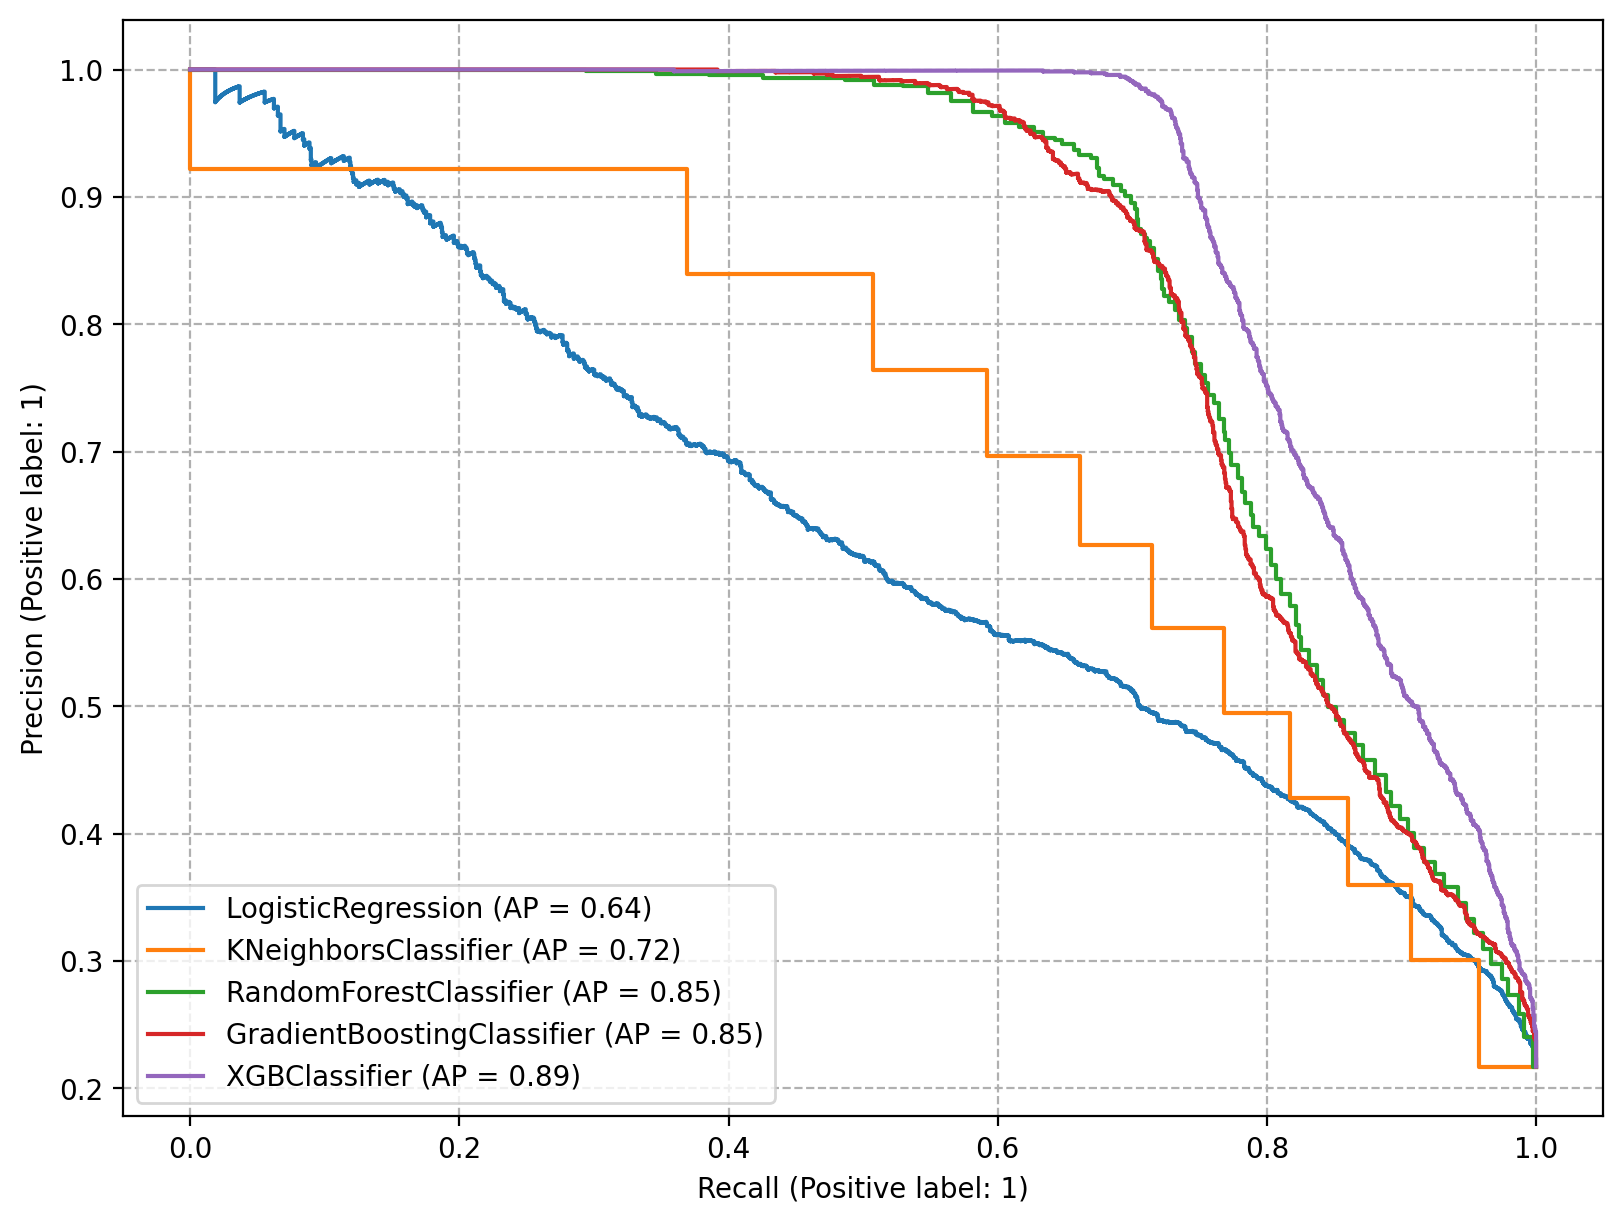

In [124]:
fig, ax_roc = plt.subplots(1, 1, figsize=(8, 6))

for clf in fitted_models_smote:
    PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc)

ax_roc.grid(linestyle="--")

plt.legend()
plt.show()

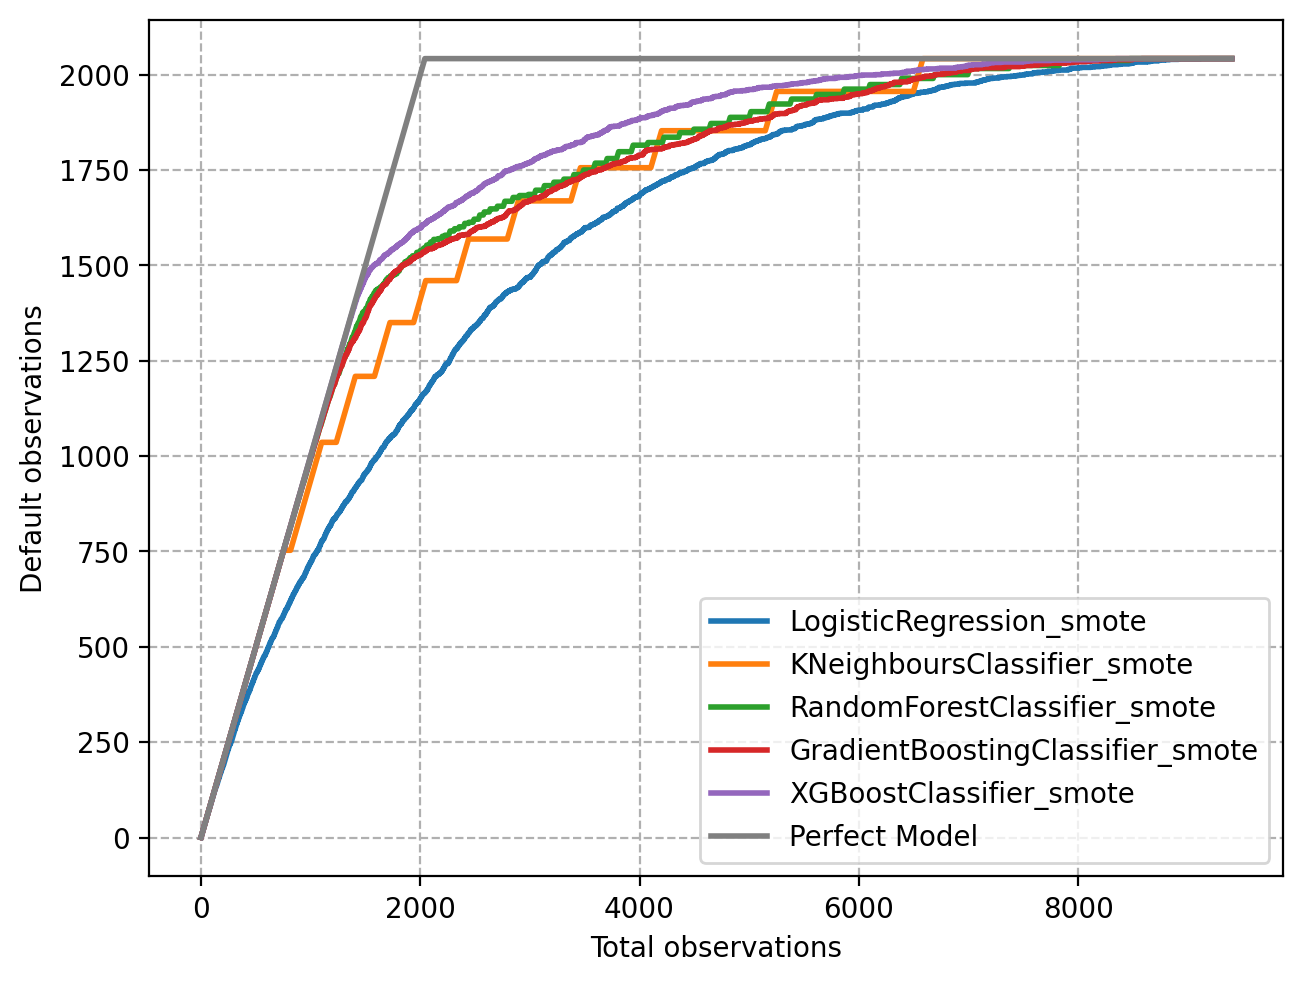

In [134]:
total = len(y_test)
one_count = np.sum(y_test)
zero_count = total - one_count

plt.figure()

x = np.arange(0, total + 1)
for name, pred in zip(model_names_smote, fitted_models_predictions_smote):
    lm = [y for _, y in sorted(zip(pred, y_test), reverse = True)]
    y = np.append([0], np.cumsum(lm))
    plt.plot(x, y, label = name, linewidth = 2)

plt.xlabel('Total observations')
plt.ylabel('Default observations')
plt.grid(linestyle="--")
plt.plot([0, one_count, total], 
         [0, one_count, one_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')
plt.legend()
plt.show()

In [126]:
df_scores = pd.DataFrame(data=fitted_models_scores_smote,index=model_names_smote,columns=score_names)

In [127]:
df_scores.style.background_gradient(axis=0, cmap='YlOrRd')

In [502]:
df_all_scores = pd.DataFrame(data=fitted_models_scores+fitted_models_scores_smote,index=model_names+model_names_smote,columns=score_names)

In [503]:
df_all_scores.style.background_gradient(axis=0, cmap='YlOrRd')